### Merging final_dataset and lemmatized final_dataset and storing into parquet file

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/msc_thesis

fd: pd.DataFrame = pd.read_pickle('final_dataset_lemmatized.pkl')
fdt: pd.DataFrame = pd.read_csv('final_dataset.csv')

TEXT_COLUMN = 'meas_action_comment_concat_3m_lemmas_string'
TARGET_COLUMN = 'target'
ACCOUNT_ID = 'account_id'
SNAPNUM = 'snapnum'

# List of keys to compare
keys = [ACCOUNT_ID, SNAPNUM]

merged_final_df = fd.merge(fdt, on=keys, how='inner', suffixes = ('', '_y'))[[ACCOUNT_ID, SNAPNUM, TEXT_COLUMN, TARGET_COLUMN]]

merged_final_df.to_parquet('final_dataset_all_columns_lemmatized.parquet')

## EDA

In [1]:
!pip install wordcloud

Mounted at /content/drive
/content/drive/MyDrive/msc_thesis
The distribution of the class is: target
0    1971877
1       3612
Name: count, dtype: int64


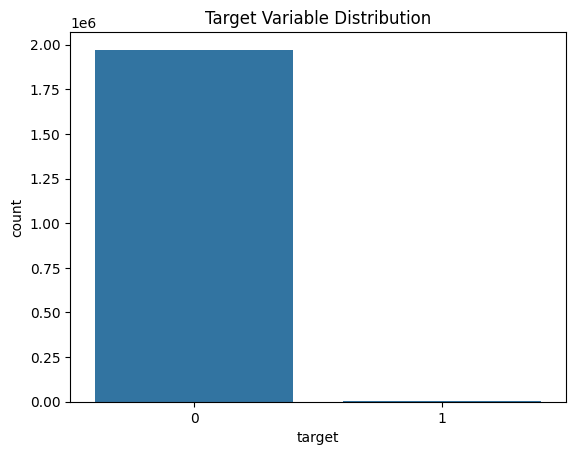

#########################
Statistics for the text lengths: count    1.975489e+06
mean     3.464808e+02
std      5.203365e+02
min      1.000000e+00
25%      6.200000e+01
50%      1.600000e+02
75%      4.040000e+02
max      3.218800e+04
Name: text_length, dtype: float64
#########################


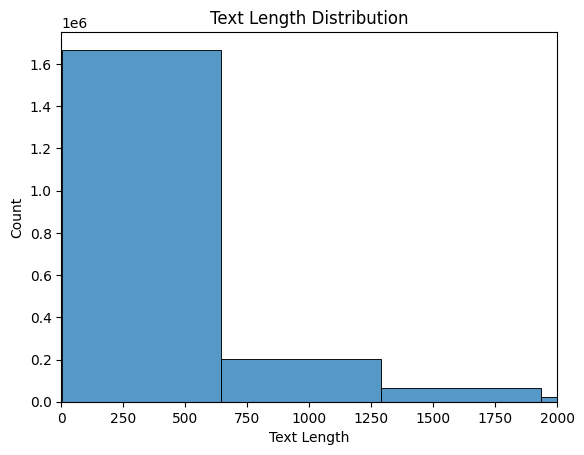

The most common words are: [('τηλεφωνο', 2724070), ('μηνυμα', 1664232), ('κατειλημμενο', 1653497), ('επικοινωνια', 1136849), ('μεσα', 979850), ('email', 973028), ('συμβαση', 965142), ('κωδικοσ', 964405), ('παρακαλω', 962587), ('τηλεφωνητησ', 905156), ('κατοχοσ', 870188), ('εχω', 560728), ('οτι', 492790), ('οφειλη', 476086), ('ενημερωση', 460829), ('λεω', 436732), ('καλω', 391606), ('τερματιζω', 382559), ('ζηταω', 368629), ('ειμαι', 361200)]
Most common words for class 0: [('τηλεφωνο', 2716609), ('μηνυμα', 1659259), ('κατειλημμενο', 1650006), ('επικοινωνια', 1133559), ('μεσα', 977409), ('email', 970672), ('συμβαση', 962909), ('κωδικοσ', 962136), ('παρακαλω', 960361), ('τηλεφωνητησ', 902935), ('κατοχοσ', 865596), ('εχω', 557196), ('οτι', 489359), ('οφειλη', 473528), ('ενημερωση', 457049), ('λεω', 434091), ('καλω', 388549), ('τερματιζω', 381594), ('ζηταω', 365888), ('ειμαι', 359378)]
Most common words for class 1: [('τηλεφωνο', 7461), ('μηνυμα', 4973), ('κατοχοσ', 4592), ('ενημερωση', 378

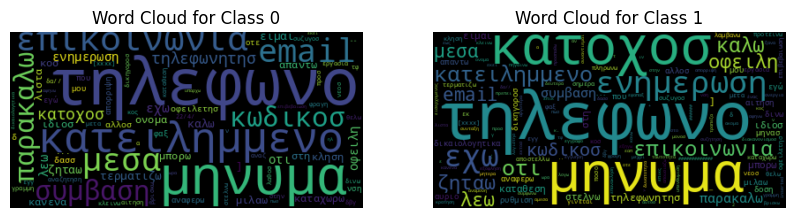

#########################


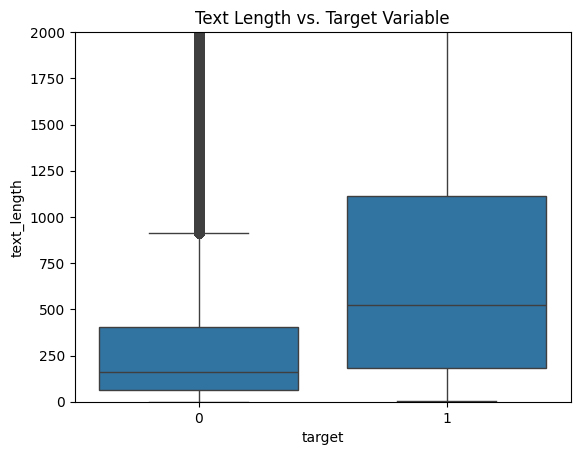

#########################
The total length of vocabulary is: 90157


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/msc_thesis
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

TEXT_COLUMN = 'meas_action_comment_concat_3m_lemmas_string'
TARGET_COLUMN = 'target'
ACCOUNT_ID = 'account_id'
SNAPNUM = 'snapnum'

merged_final_df = pd.read_parquet('final_dataset_all_columns_lemmatized.parquet')

# Check class distribution
print(f"The distribution of the class is: {merged_final_df[TARGET_COLUMN].value_counts()}")

sns.countplot(x=TARGET_COLUMN, data=merged_final_df)
plt.title('Target Variable Distribution')
plt.show()

print('#########################')
# Check the length of text entries
merged_final_df['text_length'] = merged_final_df[TEXT_COLUMN].apply(len)
print(f"Statistics for the text lengths: {merged_final_df['text_length'].describe()}")
print('#########################')

sns.histplot(merged_final_df['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.xlim(0, 2000)
plt.show()

# Words to exclude
exclude_words = ['##########', '[xxxxς]', ',', ':', 'ο', '.', '###', '(', ')', '*', 'σε', 'δα', 'απο', 'με', \
                 'δεν', 'να', 'μασ', '##', 'η', 'gr', '[xxx@xxx][xxxx]', 'θα', 'για', 'και', '/', '-', 'κ', \
                 'κα', '#####', '€', '####', '####################', 'actioncode', 'οφ', '//']

# 1. Prepare data (excluding words)

def preprocess_text(text):
    words = text.split()
    words = [word for word in words if word not in exclude_words]
    return " ".join(words)

merged_final_df['processed_text'] = merged_final_df[TEXT_COLUMN].apply(preprocess_text)

# Most Common Words
word_counts = Counter(" ".join(merged_final_df['processed_text']).split())
print(f"The most common words are: {word_counts.most_common(20)}")

# Most common words per class
class_0_words = Counter(" ".join(merged_final_df[merged_final_df[TARGET_COLUMN] == 0]['processed_text']).split())
class_1_words = Counter(" ".join(merged_final_df[merged_final_df[TARGET_COLUMN] == 1]['processed_text']).split())

print("Most common words for class 0:", class_0_words.most_common(20))
print("Most common words for class 1:", class_1_words.most_common(20))

print('#########################')

# Associations between Words and Labels
wordcloud_0 = WordCloud().generate_from_frequencies(class_0_words)
wordcloud_1 = WordCloud().generate_from_frequencies(class_1_words)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('Word Cloud for Class 0')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Word Cloud for Class 1')
plt.axis("off")
plt.show()

print('#########################')

sns.boxplot(x=TARGET_COLUMN, y='text_length', data=merged_final_df)
plt.title('Text Length vs. Target Variable')
plt.ylim(0, 2000)
plt.show()

print('#########################')

vectorizer = CountVectorizer()

texts_bow = vectorizer.fit_transform(merged_final_df['processed_text'])

dic_vocabulary = vectorizer.vocabulary_
print(f"The total length of vocabulary is: {len(dic_vocabulary)}")

sns.heatmap(texts_bow.todense()[:,np.random.randint(0, texts_bow.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Visualization of Sparse Bag-of-Words Matrix (Random Sample)')
plt.show()

### Installing dependencies

In [ ]:
!pip install transformers bitsandbytes peft datasets accelerate openai optuna polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This 

In [ ]:
import tensorflow as tf

# Check if TPU is available and uninstall tensorflow because it is creating issues
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    !pip uninstall tensorflow --y
except:
    print("TPU is not available.")

TPU is not available.


### Import dependencies, connect to Google Drive and set constants

In [ ]:
from abc import ABC, abstractmethod
from typing import Any, Optional, Type
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/msc_thesis
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertPreTrainedModel, BertTokenizer, BertForSequenceClassification, AdamW, AutoModel, AutoTokenizer, Trainer, TrainingArguments, BitsAndBytesConfig, AutoModelForSequenceClassification, EarlyStoppingCallback
from transformers.optimization import get_scheduler, get_cosine_schedule_with_warmup
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.utils import resample
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc, classification_report
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, cosine_distances

from sklearn.utils.class_weight import compute_class_weight
from huggingface_hub import login
from torch.cuda.amp import autocast, GradScaler
import re
import openai
import time
import os
import optuna
import polars as pl
import pickle
import gc
from itertools import cycle
import json


DOWNSAMPLING_RATIO = 0.1
TEXT_COLUMN = 'meas_action_comment_concat_3m_lemmas_string'
CLEANED_TEXT_COLUMN = 'cleaned_text'
GPT_REFINED_TEXT_COLUMN = 'gpt_refined_text'
TARGET_COLUMN = 'target'
LABEL_COLUMN = 'label'
ACCOUNT_ID = 'account_id'
SNAPNUM = 'snapnum'
DEDUPLICATED = 'deduplicated'
TRAIN_DATA = 'train_data'
VALIDATION_DATA = 'validation_data'
TEST_DATA = 'test_data'
NEGATIVE_DOWNSAMPLED = 'neg_downsampled'
GREEK_BERT = 'greek_bert'
RESAMPLING = 'resampling'
GREEK_BERT_MODEL = 'nlpaueb/bert-base-greek-uncased-v1'
FINBERT = 'finbert'
MELTEMI = 'meltemi'
MELTEMI_MODEL = 'ilsp/Meltemi-7B-v1'
CONTRASTIVE_LEARNING = 'contrastive_learning'
CONTRASTIVE_LEARNING_ALT = 'contrastive_learning_alt'
LORA = 'lora'
QLORA = 'qlora'
CLASS_WEIGHTS = 'class_weights'
OPTUNA = 'optuna'
LEARNING_RATE_DECAY = 'learning_rate_decay'
GPT_REFINED = 'gpt_refined'
GPT_SYNTHETIC = 'gpt_synthetic'
E5_MULTILINGUAL_MODEL = 'intfloat/multilingual-e5-large'
XLM_ROBERTA = 'xlm_roberta'
XLM_ROBERTA_MODEL = 'xlm-roberta-base'
LLAMA = 'llama_3_1'
TRAIN_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME = f'{GREEK_BERT}_{DEDUPLICATED}_{TRAIN_DATA}_{NEGATIVE_DOWNSAMPLED}.csv'
VALIDATION_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME = f'{GREEK_BERT}_{DEDUPLICATED}_{VALIDATION_DATA}_{NEGATIVE_DOWNSAMPLED}.csv'
TEST_DATA_FILE_NAME = f'{GREEK_BERT}_{DEDUPLICATED}_{TEST_DATA}.csv'
TEST_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME = f'{GREEK_BERT}_{DEDUPLICATED}_{TEST_DATA}_{NEGATIVE_DOWNSAMPLED}.csv'
CONTRASTIVE_PAIRS_FILE_NAME = 'contrastive_pairs.json'
CONTRASTIVE_PAIRS_ALT_FILE_NAME = 'contrastive_pairs_alt.json'
CONTRASTIVE_LEARNING_TRAIN_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME = f'{CONTRASTIVE_LEARNING}_{DEDUPLICATED}_{TRAIN_DATA}_{NEGATIVE_DOWNSAMPLED}.csv'
CONTRASTIVE_LEARNING_VALIDATION_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME = f'{CONTRASTIVE_LEARNING}_{DEDUPLICATED}_{VALIDATION_DATA}_{NEGATIVE_DOWNSAMPLED}.csv'

Mounted at /content/drive
/content/drive/MyDrive/msc_thesis


### Helper functions for Train-Test split, data validation, evaluation metrics

In [ ]:
def check_stratified_group_train_test_split(input_df: pd.DataFrame, train_data: pd.DataFrame, test_data:pd.DataFrame):
    """
    LEGACY FUNCTION using Pandas - See the updated Polars version below
    Used to check the split made by the stratified_group_train_test_split function, to see:
      - If for the account ids that occur both in the train and the test set, there are train samples that overlap chronologically with the test samples
      - If the total length of the train and test data is equal to the initial dataset
      - If the imbalance of the classes is retained in the train and test datasets
    """
    unique_train_ids = set(train_data[ACCOUNT_ID].unique())

    unique_test_ids = set(test_data[ACCOUNT_ID].unique())

    common_ids = unique_train_ids.intersection(unique_test_ids)

    ii = 0
    jj = 0

    train_snapnums: pd.DataFrame
    test_snapnums: pd.DataFrame
    # Assuming common_ids is the set of account_ids present in both train and test data
    for account_id in common_ids:
        if ii < 1000:
            # Filter train_data and test_data for the current account_id
            train_snapnums = train_data[train_data[ACCOUNT_ID] == account_id][SNAPNUM]
            test_snapnums = test_data[test_data[ACCOUNT_ID] == account_id][SNAPNUM]

            # Check if the max snapnum in train_data is less than the min snapnum in test_data
            if train_snapnums.max() >= test_snapnums.min():
                print(f"Account ID {account_id} has overlap or disorder in snapnum")
                jj += 1
        else:
            break
        ii += 1

    if jj != 0:
        raise Exception(
            "There are account_ids with wrong data in the test set (not in the future compared with the train data for the same id)"
        )

    if len(input_df) != len(train_data) + len(test_data):
        raise Exception(
            "The total length of train + test data are less than the initial dataset"
        )

    if not (
        float(
            train_data[TARGET_COLUMN].value_counts()[1]
            / train_data[TARGET_COLUMN].value_counts()[0]
        )
        >= 0.001
    ):
        raise Exception(
            "The imbalance of the classes is not retained in the train dataset"
        )

    if not (
        float(
            test_data[TARGET_COLUMN].value_counts()[1]
            / test_data[TARGET_COLUMN].value_counts()[0]
        )
        >= 0.001
    ):
        raise Exception(
            "The imbalance of the classes is not retained in the test dataset"
        )



def stratified_group_train_test_split(input_df: pd.DataFrame, folds: int = 5, random_state: int = 17) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    LEGACY FUNCTION using Pandas - See the updated Polars version below
    Used to be used so that the dataset is split into train and test sets using a mix of StratifiedKFold and StratifiedGroupKFold
    For the account_ids that have less samples than the number of folds (n=5 for 80-20 split), StratifiedGroupKFold is used (an account_id would exist in either the train or the test set)
    For the account_ids that have more samples than the number of folds for all classes (n=5 for 80-20 split), StratifiedKFold is used (these account_ids exist in both the train and test set.
        Their instances are ordered chronologically in descending order, so that the first sample is in the future, because StratifiedKFold in the first fold takes the first sample for the test set)
    In both cases, only the first iteration of the loop is used, so that the function returns only one split (80-20)
    At the end, the function checks if the train and test sets are correctly split
    """
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # We sort the dataset in descending order because StratifiedKFold in the first fold takes the first sample for the test set
    # So the first sample must be in the future for the account_ids that occur both in the train and test set

    input_df = input_df.sort_values(by=[ACCOUNT_ID, SNAPNUM], ascending=False).reset_index(drop=True)
    unique_ids = input_df[ACCOUNT_ID].unique()

    repeated_ids = []

    # The number of samples must be greater than or equal to the number of folds, so that StratifiedKFold can split each id's sub-dataset
    for unique_id in unique_ids:
        check_class_instances_greater_than_n_folds = [cnt >= folds for cnt in input_df[input_df[ACCOUNT_ID] == unique_id][TARGET_COLUMN].value_counts()]
        if len(input_df[input_df[ACCOUNT_ID] == unique_id]) >= folds and all(check_class_instances_greater_than_n_folds):
            repeated_ids.append(unique_id)

    # All account ids that have less samples than the number of folds are split using StratifiedGroupKFold
    new_ids = list(set(unique_ids) - set(repeated_ids))
    new_account_data = input_df[input_df[ACCOUNT_ID].isin(new_ids)].copy()

    sgkf = StratifiedGroupKFold(n_splits=folds, shuffle=True, random_state=random_state)
    for train_index, test_index in sgkf.split(
        new_account_data,
        new_account_data[TARGET_COLUMN],
        groups=new_account_data[ACCOUNT_ID],
    ):
        train_part, test_part = new_account_data.iloc[train_index], new_account_data.iloc[test_index]

        # We sort by again in ascending order but this was not necessary because the split here reassures that an account_id that exists in the train set
        # cannot also exist in the test set
        train_part = train_part.sort_values(by=[ACCOUNT_ID, SNAPNUM], ascending=True).reset_index(drop=True)
        test_part = test_part.sort_values(by=[ACCOUNT_ID, SNAPNUM], ascending=True).reset_index(drop=True)

        train_data = pd.concat([train_data, train_part], ignore_index=True)
        test_data = pd.concat([test_data, test_part], ignore_index=True)
        break

    # Fpr the repeated ids, we are using StratifiedKFold because it can retain the chronological order of the records (shuffle must be False!)
    skf = StratifiedKFold(n_splits=folds, shuffle=False)

    for repeated_id in repeated_ids:
        account_data: pd.DataFrame = input_df[input_df[ACCOUNT_ID] == repeated_id].copy()
        for train_index, test_index in skf.split(account_data, account_data[TARGET_COLUMN]):
            train_part: pd.DataFrame
            test_part: pd.DataFrame
            train_part, test_part = account_data.iloc[train_index], account_data.iloc[test_index]

            # Here again the ascending order was not necessary
            train_part = train_part.sort_values(by=[SNAPNUM], ascending=True).reset_index(drop=True)
            train_data = pd.concat([train_data, train_part], ignore_index=True)
            test_data = pd.concat([test_data, test_part], ignore_index=True)
            break

    check_stratified_group_train_test_split(input_df, train_data, test_data)
    return train_data, test_data


def pl_check_stratified_group_train_test_split(input_df: pl.LazyFrame, train_data: pl.DataFrame, test_data: pl.DataFrame):
    """
    Optimized function using Polars
    """
    unique_train_ids = set(train_data.select(pl.col(ACCOUNT_ID)).unique().to_series().to_list())
    unique_test_ids = set(test_data.select(pl.col(ACCOUNT_ID)).unique().to_series().to_list())

    common_ids = unique_train_ids.intersection(unique_test_ids)

    ii = 0
    jj = 0

    for account_id in common_ids:
        if ii < 1000:
            train_snapnums = train_data.filter(pl.col(ACCOUNT_ID) == account_id).select(SNAPNUM)
            test_snapnums = test_data.filter(pl.col(ACCOUNT_ID) == account_id).select(SNAPNUM)

            if train_snapnums.max()[0, 0] >= test_snapnums.min()[0, 0]:
                print(f"Account ID {account_id} has overlap or disorder in snapnum")
                jj += 1
        else:
            break
        ii += 1

    if jj != 0:
        raise Exception(
            "There are account_ids with wrong data in the test set (not in the future compared with the train data for the same id)"
        )

    if input_df.collect().shape[0] != (train_data.shape[0] + test_data.shape[0]):
        raise Exception(
            "The total length of train + test data are less than the initial dataset"
        )

    counts_df = train_data.select(pl.col(TARGET_COLUMN).value_counts())
    counts = counts_df.get_column('target')
    train_ratio = counts[1]['count'] / counts[0]['count']

    counts_df = test_data.select(pl.col(TARGET_COLUMN).value_counts())
    counts = counts_df.get_column('target')
    test_ratio = counts[1]['count'] / counts[0]['count']

    if not (
        float(
            train_ratio
        )
        >= 0.001
    ):
        raise Exception(
            "The imbalance of the classes is not retained in the train dataset"
        )

    if not (
        float(
            test_ratio
        )
        >= 0.001
    ):
        raise Exception(
            "The imbalance of the classes is not retained in the test dataset"
        )



def pl_stratified_group_train_test_split(input_df: pl.LazyFrame, folds: int = 5, random_state: int = 17):
    """
    Optimized function using Polars with lazy evaluation
    """
    input_df = input_df.sort([ACCOUNT_ID, SNAPNUM], descending=[True, True])

    input_df_collected = input_df.collect()

    if not isinstance(input_df_collected, pl.DataFrame):
        input_df_collected = pl.DataFrame(input_df_collected)

    # First, count the number of times each target value appears per ACCOUNT_ID
    counts_per_target = input_df_collected.group_by([ACCOUNT_ID, TARGET_COLUMN]).agg(
        pl.len().alias('labels_count')
    )

    # Now, compute total_count for each target class per ACCOUNT_ID
    id_counts = counts_per_target.pivot(
        index=ACCOUNT_ID,
        on=TARGET_COLUMN,
        values='labels_count'
    ).fill_null(0)

    # Ensure both '0' and '1' target classes are present
    id_counts = id_counts.with_columns([
        (pl.col('0') >= folds).alias('enough_zeros'),
        (pl.col('1') >= folds).alias('enough_ones')
    ])

    id_counts = id_counts.filter(pl.col(ACCOUNT_ID).is_not_null() & (pl.col(ACCOUNT_ID) != 0.0))

    # Filter repeated ids where both classes have enough samples
    repeated_ids = id_counts.filter(
        (pl.col('enough_zeros')) & (pl.col('enough_ones'))
    )[ACCOUNT_ID].to_list()


    # Split data into repeated and new accounts
    repeated_account_data = input_df_collected.filter(pl.col(ACCOUNT_ID).is_in(repeated_ids))
    new_account_data = input_df_collected.filter(~pl.col(ACCOUNT_ID).is_in(repeated_ids))

    # Convert to pandas DataFrames for scikit-learn compatibility
    new_account_data_pd = new_account_data.to_pandas()
    repeated_account_data_pd = repeated_account_data.to_pandas()

    # Split new accounts using StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=folds, shuffle=True, random_state=random_state)
    train_index, test_index = next(sgkf.split(
        new_account_data_pd,
        new_account_data_pd[TARGET_COLUMN],
        groups=new_account_data_pd[ACCOUNT_ID]
    ))

    train_data = pl.from_pandas(new_account_data_pd.iloc[train_index])
    test_data = pl.from_pandas(new_account_data_pd.iloc[test_index])

    # Split repeated accounts using StratifiedKFold
    skf = StratifiedKFold(n_splits=folds, shuffle=False)
    for account_id in repeated_ids:
        account_data_pd = repeated_account_data_pd[repeated_account_data_pd[ACCOUNT_ID] == account_id]
        y = account_data_pd[TARGET_COLUMN].values
        train_idx, test_idx = next(skf.split(account_data_pd, y))
        train_data = pl.concat([train_data, pl.from_pandas(account_data_pd.iloc[train_idx])])
        test_data = pl.concat([test_data, pl.from_pandas(account_data_pd.iloc[test_idx])])

    # Optionally, perform a check on the collected data
    # check_stratified_group_train_test_split(input_df_collected, train_data, test_data)

    return train_data, test_data


def stratified_train_test_split(dataset: pd.DataFrame, target_column: str = TARGET_COLUMN, folds:int = 5, random_state:int = 17) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Performs a stratified split on the input DataFrame based on the target column.
    """
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for train_index, test_index in skf.split(dataset, dataset[target_column]):
        train_part: pd.DataFrame
        test_part: pd.DataFrame
        train_part, test_part = (
            dataset.iloc[train_index],
            dataset.iloc[test_index],
        )

        # Here again the ascending order was not necessary
        train_data = pd.concat([train_data, train_part])
        test_data = pd.concat([test_data, test_part])
        break

    return train_data, test_data

# Metrics calculation
def compute_metrics(p, k=20):
    """
    Computes ranking metrics and traditional metrics for the positive class.
    """
    preds = np.argmax(p.predictions, axis=1)
    probabilities = p.predictions[:, 1]  # Probabilities for the positive class
    labels = p.label_ids  # True labels

    # Traditional metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    # Precision@K
    top_k_indices = np.argsort(probabilities)[::-1][:k]
    precision_at_k = np.mean(labels[top_k_indices]) if len(labels[top_k_indices]) > 0 else 0

    # Recall@K
    num_positives = np.sum(labels)
    recall_at_k = np.sum(labels[top_k_indices]) / num_positives if num_positives > 0 else 0

    # R-Precision
    r = num_positives  # Total number of positives
    top_r_indices = np.argsort(probabilities)[::-1][:r]
    r_precision = np.sum(labels[top_r_indices]) / r if r > 0 else 0

    # PR-AUC
    precision_curve, recall_curve, _ = precision_recall_curve(labels, probabilities)
    pr_auc = auc(recall_curve, precision_curve)

    # ROC-AUC
    roc_auc = roc_auc_score(labels, probabilities)

    # Return metrics
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "precision@k": precision_at_k,
        "recall@k": recall_at_k,
        "r_precision": r_precision,
        "pr_auc": pr_auc,
        "roc_auc": roc_auc,
    }

def tokenize_function_for_gpt_refined(examples):
    tokenized_inputs = tokenizer(
        examples[GPT_REFINED_TEXT_COLUMN],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    # Add the labels back to the tokenized dataset
    tokenized_inputs["labels"] = examples[LABEL_COLUMN]
    return tokenized_inputs

## Defining classes and methods for:
### - Creating classes and methods for datasets creation (deduplication and downsampling of negative class)
## +
### - Experiment 1: Finetuning GreekBERT using Optuna hyperparameter optimization and evaluation

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


class PretrainedModel(ABC):
    @classmethod
    @abstractmethod
    def from_pretrained(cls, model_name_or_path: str, *args, **kwargs) -> Any:
        """Load a pretrained model from the specified path or model name."""
        pass


class ClassificationBertModel(BertForSequenceClassification, PretrainedModel):
    pass

class InvalidInputDataException(Exception):
    pass

class ExperimentHandler:
    def __init__(
            self,
            experiment_name: str,
            model_class: Type[PretrainedModel],
            model_save_path: str,
            experiment_dataset: Optional[pd.DataFrame] = None,
            text_column: str = TEXT_COLUMN,
            target_column: str = TARGET_COLUMN,
            model_load_path: Optional[str] = None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.experiment_dataset = experiment_dataset
        self.text_column = text_column
        self.target_column = target_column
        self.experiment_name = experiment_name
        self.model_class = model_class
        if model_load_path:
            self.model = self.model_class.from_pretrained(model_load_path, num_labels=2)
        else:
            self.model = self.model_class.from_pretrained(GREEK_BERT_MODEL, num_labels=2)
        self.model_save_path = model_save_path
        self.tokenizer = BertTokenizer.from_pretrained(GREEK_BERT_MODEL)
        os.makedirs(self.experiment_name, exist_ok=True)


    def prepare_train_val_test_data(self, downsampling_ratio: Optional[float] = None, train_data: Optional[pd.DataFrame] = None, test_data: Optional[pd.DataFrame] = None, train_data_path: Optional[str] = None, validation_data_path: Optional[str] = None, test_data_path: Optional[str] = None):
        """
        Prepares the train, validation and test data for the experiment by:
            - Sequentially stratified splitting
            - Downsampling the negative class (only in the train and validation datasets)
            - Saving the train, validation and test data to CSV files
        """
        if train_data is not None and test_data is not None:
            if self.experiment_dataset is not None:
                raise InvalidInputDataException("Either experiment_dataset or (train_data and test_data) must be provided.")
            self.train_data = train_data
            self.test_data = test_data
        elif (train_data is not None and test_data is None) or (test_data is not None and train_data is None):
            raise InvalidInputDataException("Both train and test data must be provided.")
        else:
            if self.experiment_dataset is None:
                raise InvalidInputDataException("experiment_dataset must be provided.")
            self.train_data, self.test_data = stratified_train_test_split(self.experiment_dataset, self.target_column, folds=8)
        self.train_data, self.validation_data = stratified_train_test_split(self.train_data, self.target_column, folds=5)

        if downsampling_ratio:
            self.train_data = self._downsample_negative_class(self.train_data, downsampling_ratio)
            self.validation_data = self._downsample_negative_class(self.validation_data, downsampling_ratio)
        if train_data_path:
            self.train_data.to_csv(f'{self.experiment_name}/{train_data_path}', index=False)
        if validation_data_path:
            self.validation_data.to_csv(f'{self.experiment_name}/{validation_data_path}', index=False)
        if test_data_path:
            self.test_data.to_csv(f'{self.experiment_name}/{test_data_path}', index=False)

    def _downsample_negative_class(self, dataset: pd.DataFrame, frac=0.01, random_state=42) -> pd.DataFrame:
        """
        Downsamples the negative class in the dataset to the specified fraction.
        """
        negative_data = dataset[dataset[self.target_column] == 0].sample(frac=frac, random_state=random_state)
        positive_data = dataset[dataset[self.target_column] == 1]
        data_negative_downsampled = pd.concat([positive_data, negative_data]).sample(frac=1.0, random_state=random_state).reset_index(drop=True)
        return data_negative_downsampled


    def extract_pooled_output_logits_loss(self, input_ids, attention_mask, labels=None, model=None):
        """
        Extracts the pooler output, logits, and loss from the model.
        Args:
            input_ids: Tokenized input IDs.
            attention_mask: Attention mask for input.
            labels: Optional. Ground truth labels for calculating loss.

        Returns:
            pooler_output: The pooled output from the model.
            logits: The logits from the classifier layer.
            loss: Loss value (if labels are provided), otherwise None.
        """
        if not model:
            model = self.model

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        if isinstance(model, ClassificationBertModel):
            # Extract components
            pooler_output = None
            logits = outputs.logits
            loss = outputs.loss if labels is not None else None
        elif isinstance(model, ContrastiveClassificationBertModel):
            pooler_output = outputs.pooler_output  # Extract pooled output for contrastive loss
            logits = model.classifier(pooler_output)  # Pass pooled output through classifier for logits
            loss = None

            # If labels are provided, calculate classification loss
            if labels is not None:
                criterion = nn.CrossEntropyLoss()  # Define loss function for classification
                loss = criterion(logits, labels)


        return pooler_output, logits, loss


    def train_model(
        self,
        num_epochs: int,
        batch_size: int,
        accumulation_steps: int,
        learning_rate: float,
        hyperparam_optimization: bool = False
    ):
        """
        Trains the model using the validation set for early stopping or monitoring.
        At the end of training, returns predictions, true labels, and probabilities from validation.
        """
        texts_train = list(self.train_data[self.text_column])
        labels_train = list(self.train_data[self.target_column])
        texts_val = list(self.validation_data[self.text_column])
        labels_val = list(self.validation_data[self.target_column])

        train_dataset = TextDataset(texts_train, labels_train, self.tokenizer)
        val_dataset = TextDataset(texts_val, labels_val, self.tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        self.model.to(self.device)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

        best_val_loss = float('inf')

        early_stopping_patience = 3  # Number of epochs to wait for improvement
        no_improvement_count = 0

        for epoch in range(num_epochs):
            epoch_loss = 0
            self.model.train()

            for step, batch in enumerate(tqdm(train_loader)):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                _, logits, loss = self.extract_pooled_output_logits_loss(input_ids, attention_mask, labels)
                loss.backward()
                epoch_loss += loss.item()

                if (step + 1) % accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()

            avg_train_loss = epoch_loss / len(train_loader)
            print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}")

            # Validation after each epoch
            val_loss, _, _, _ = self.evaluate_on_validation_set(val_loader)
            print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}")

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                if not hyperparam_optimization:
                    self.model.save_pretrained(f"{self.experiment_name}/{self.model_save_path}")
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if no_improvement_count >= early_stopping_patience:
                    print("Early stopping triggered.")
                    break

            scheduler.step(val_loss)

        if not hyperparam_optimization:
            # Load the best model across all epochs again
            self.model = self.model_class.from_pretrained(f"{self.experiment_name}/{self.model_save_path}", num_labels=2)
            self.model.to(self.device)

            # After training, get final validation predictions, true labels, and probabilities based on the best model
            final_val_loss, final_val_predictions, final_val_true_labels, final_val_probabilities = self.evaluate_on_validation_set(val_loader)

            return self.model, final_val_predictions, final_val_true_labels, final_val_probabilities

        else:
            return self.model


    def evaluate_on_validation_set(self, val_loader):
        """
        Evaluates the model on the validation set to monitor validation loss and return predictions, true labels, and probabilities.
        """
        self.model.eval()
        val_loss = 0

        all_predictions = []
        all_true_labels = []
        all_probabilities = []

        for batch in val_loader:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            with torch.no_grad():
                _, logits, loss = self.extract_pooled_output_logits_loss(input_ids, attention_mask, labels)
                val_loss += loss.item()

                probabilities = torch.softmax(logits, dim=1)  # Probabilities for each class
                predictions = torch.argmax(logits, dim=1)  # Predicted class

                all_probabilities.extend(probabilities.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)

        return avg_val_loss, all_predictions, all_true_labels, all_probabilities


    def evaluate_model(self, batch_size: int = 16, trained_model=None, model_path=None):
        """
        Evaluates the model on the test data and calculates accuracy, precision, recall, f1 score.
        """
        if trained_model is None and model_path is None:
            trained_model = self.model
        elif trained_model is None:
            trained_model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

        trained_model = trained_model.to(self.device)

        test_texts = list(self.test_data[self.text_column])
        test_labels = list(self.test_data[self.target_column])

        test_dataset = TextDataset(test_texts, test_labels, self.tokenizer)
        test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        predictions = []
        true_labels = []
        probabilities = []

        trained_model.eval()

        for batch in test_data_loader:
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            with torch.no_grad():
                _, logits, loss = self.extract_pooled_output_logits_loss(input_ids, attention_mask, labels, model=trained_model)

            probs = torch.softmax(logits, dim=-1)

            probabilities.extend(probs.cpu().tolist())
            predictions.extend(logits.argmax(dim=-1).cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        conf_matrix = pd.crosstab(pd.Series(true_labels), pd.Series(predictions), rownames=['True'], colnames=['Predicted'], margins=True)

        print(f"{self.experiment_name} - Accuracy: {accuracy}")
        print(f"{self.experiment_name} - Precision: {precision}")
        print(f"{self.experiment_name} - Recall: {recall}")
        print(f"{self.experiment_name} - F1 Score: {f1}")
        print(f"{self.experiment_name} - Confusion Matrix:\n{conf_matrix}")

        results = pd.DataFrame({
            "accuracy": [accuracy],
            "precision": [precision],
            "recall": [recall],
            "f1": [f1],
        })

        results.to_csv(f'{self.experiment_name}/results.csv', index=False)

        return predictions, true_labels, probabilities, results

    def objective(self, trial):
        """
        Optuna objective function for hyperparameter tuning.
        """
        best_val_loss = float('inf')

        num_epochs = trial.suggest_int('num_epochs', 2, 5)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
        accumulation_steps = trial.suggest_int('accumulation_steps', 1, 4)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 2e-4)

        self.model = self.train_model(num_epochs=num_epochs, batch_size=batch_size,
                                      accumulation_steps=accumulation_steps, learning_rate=learning_rate,
                                      hyperparam_optimization=True)

        val_texts = list(self.validation_data[self.text_column])
        val_labels = list(self.validation_data[self.target_column])

        val_dataset = TextDataset(val_texts, val_labels, self.tokenizer)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        val_loss, _, _, _ = self.evaluate_on_validation_set(val_loader)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            self.model.save_pretrained(f"{self.experiment_name}/{self.model_save_path}")

        return val_loss

    def tune_hyperparameters(self, n_trials: int = 10):
        """
        Uses Optuna to find the best hyperparameters.
        """
        study = optuna.create_study(direction='minimize')
        study.optimize(self.objective, n_trials=n_trials)

        print(f"Best hyperparameters: {study.best_params}")

        optuna_best_params_df = pd.DataFrame([study.best_params])
        optuna_best_params_df.to_csv(f'{self.experiment_name}/optuna_best_params.csv', index=False)

        return study.best_params

    def evaluate_as_ranker(self, true_labels, probabilities, k: int = 20, trained_model=None, model_path=None) -> pd.DataFrame:
        """
        Evaluates the model as a ranker using ROC-AUC, PR-AUC, R-Precision, Recall@K, and Precision@K.
        """
        # Keep only probabilities for the positive class
        positive_class_probs = [prob[1] for prob in probabilities]

        # Calculate Ranking Metrics
        roc_auc = roc_auc_score(true_labels, positive_class_probs)

        precision, recall, _ = precision_recall_curve(true_labels, positive_class_probs)
        pr_auc = auc(recall, precision)

        # R-Precision (number of relevant documents in top `num_relevant` positions)
        num_relevant = sum(true_labels)
        sorted_indices = np.argsort(-np.array(positive_class_probs))  # Sort by probability descending

        top_r_indices = sorted_indices[:num_relevant]
        r_precision = sum(np.array(true_labels)[top_r_indices]) / num_relevant if num_relevant > 0 else 0

        # Recall@K and Precision@K
        if k > len(positive_class_probs):
            k = len(positive_class_probs)
        top_k_indices = sorted_indices[:k]
        recall_at_k = sum(np.array(true_labels)[top_k_indices]) / num_relevant if num_relevant > 0 else 0
        precision_at_k = sum(np.array(true_labels)[top_k_indices]) / k if k > 0 else 0

        print(f"ROC-AUC: {roc_auc}")
        print(f"PR-AUC: {pr_auc}")
        print(f"R-Precision: {r_precision}")
        print(f"Recall@{k}: {recall_at_k}")
        print(f"Precision@{k}: {precision_at_k}")

        results = pd.DataFrame({
            "ROC-AUC": [roc_auc],
            "PR-AUC": [pr_auc],
            "R-Precision": [r_precision],
            "Recall@K": [recall_at_k],
            "Precision@K": [precision_at_k]
        })

        results.to_csv(f'{self.experiment_name}/results_ranker.csv', index=False)

        return results


class DeduplicatedNegativeDownsampledExperimentHandler(ExperimentHandler):
    def __init__(
            self,
            experiment_name: str,
            model_class: Type[PretrainedModel],
            model_save_path: str,
            experiment_dataset: Optional[pd.DataFrame] = None,
            text_column: str = TEXT_COLUMN,
            target_column: str = TARGET_COLUMN,
            model_load_path: Optional[str] = None
            ):
        super().__init__(experiment_name, model_class, model_save_path, experiment_dataset, text_column, target_column, model_load_path)


    def prepare_train_val_test_data(
            self,
            downsampling_ratio: Optional[float] = None,
            train_data: Optional[pd.DataFrame] = None,
            test_data: Optional[pd.DataFrame] = None,
            train_data_path: Optional[str] = None,
            validation_data_path: Optional[str] = None,
            test_data_path: Optional[str] = None
        ):
        """
        Prepares the train and test data for the experiment by:
            - Deduplicating the texts and classes
            - Stratified 70 (train) - 17.5 (validation) - 12.5 (test) split
            - Downsampling the negative class in train and validation data
            - Saving the train, validation and test data to CSV files
        """
        if train_data is not None and test_data is not None:
            if self.experiment_dataset is not None:
                raise InvalidInputDataException("Either experiment_dataset or (train_data and test_data) must be provided.")
            self.train_data = train_data
            self.test_data = test_data
        elif (train_data is not None and test_data is None) or (test_data is not None and train_data is None):
            raise InvalidInputDataException("Both train and test data must be provided.")
        else:
            if self.experiment_dataset is None:
                raise InvalidInputDataException("experiment_dataset must be provided.")
            self.lazy_pl_cleaned_dataset = self._deduplicate_dataset()

            print("Deduplication has been completed. Starting the checks for deduplication...")
            self._check_dataset_deduplication()

            print("Deduplication checks have been passed. Starting the splitting process...")
            self.pl_train_data_initial, self.pl_test_data = pl_stratified_group_train_test_split(self.lazy_pl_cleaned_dataset, folds=8)
            self.pl_train_data_final, self.pl_validation_data = pl_stratified_group_train_test_split(self.pl_train_data_initial.lazy(), folds=5)

            print("Train - validation - test datasets split has been completed. Starting checks for the splitting process...")
            pl_check_stratified_group_train_test_split(self.lazy_pl_cleaned_dataset, self.pl_train_data_initial, self.pl_test_data)
            pl_check_stratified_group_train_test_split(self.pl_train_data_initial.lazy(), self.pl_train_data_final, self.pl_validation_data)

            print("All splitting checks have been passed. Persisting the datasets to drive...")

            self.train_data_initial = self.pl_train_data_initial.to_pandas()
            self.test_data = self.pl_test_data.to_pandas()
            self.validation_data = self.pl_validation_data.to_pandas()
            self.train_data_final = self.pl_train_data_final.to_pandas()

            self.train_data_without_neg_downsampled = self.train_data_final.reset_index(drop=True)
            # Downsampling the negative class in train data
            if downsampling_ratio:
                self.train_data = self._downsample_negative_class(self.train_data_final, frac=downsampling_ratio, random_state=42)
            else:
                self.train_data = self.train_data_final.reset_index(drop=True)

            self.validation_data_without_neg_downsampled = self.validation_data.reset_index(drop=True)
            # Downsampling the negative class in validation data
            if downsampling_ratio:
                self.validation_data = self._downsample_negative_class(self.validation_data, frac=downsampling_ratio, random_state=42)
            else:
                self.validation_data = self.validation_data.reset_index(drop=True)

            # Downsampling the negative class in test data
            if downsampling_ratio:
                self.test_data_neg_downsampled = self._downsample_negative_class(self.test_data, frac=downsampling_ratio, random_state=42)
                self.test_data_neg_downsampled.to_csv(f'{self.experiment_name}/{TEST_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME}', index=False)
            self.test_data = self.test_data.reset_index(drop=True)

            if train_data_path:
                self.train_data.to_csv(f'{self.experiment_name}/{train_data_path}', index=False)

            if validation_data_path:
                self.validation_data.to_csv(f'{self.experiment_name}/{validation_data_path}', index=False)

            if test_data_path:
                self.test_data.to_csv(f'{self.experiment_name}/{test_data_path}', index=False)

            print(f"Train data size: {len(self.train_data_without_neg_downsampled)}")
            print(f"Train data neg downsampled size: {len(self.train_data)}")
            print(f"Validation data size: {len(self.validation_data_without_neg_downsampled)}")
            print(f"Validation data neg downsampled size: {len(self.validation_data)}")
            print(f"Test data size: {len(self.test_data)}")
            print(f"Test data neg downsampled size: {len(self.test_data_neg_downsampled)}")



    def _get_most_common_target(self, group: pd.DataFrame) -> int:
        """
        LEGACY FUNCTION - It has been replaced by _deduplicate_dataset()
        Find the most common class for a given text, which re-occurs with both 0 and 1 targets.
        """
        target_counts = group[self.target_column].value_counts()
        return 1 if target_counts.get(1, 0) >= target_counts.get(0, 0) else 0


    def _deduplicate_texts_and_classes(self) -> pd.DataFrame:
        """
        LEGACY FUNCTION - It has been replaced by _deduplicate_dataset()
        Keeps only the text column and the target column in the DataFrame, and removes duplicates by:
            - retaining the most common target for texts that have both 0 and 1 targets
            - keeping unique texts with their targets for the rest of the texts
            - concatenating both results
        """

        distinct_texts_targets_df = self.experiment_dataset.drop_duplicates(subset=[self.text_column, self.target_column])
        texts_with_both_targets = distinct_texts_targets_df.groupby(self.text_column).filter(lambda x: set(x[self.target_column]) == {0, 1})
        unique_texts = texts_with_both_targets[self.text_column].unique()

        most_common_targets = self.experiment_dataset[self.experiment_dataset[self.text_column].isin(unique_texts)].groupby(self.text_column).apply(self._get_most_common_target).reset_index()
        most_common_targets.columns = [self.text_column, self.target_column]

        remaining_texts = self.experiment_dataset[~self.experiment_dataset[self.text_column].isin(unique_texts)].drop_duplicates(subset=[self.text_column, self.target_column])

        deduplicated_final_df = pd.concat([most_common_targets, remaining_texts], ignore_index=True)

        return deduplicated_final_df


    def _deduplicate_dataset(self) -> pl.LazyFrame:
        """
        Deduplicates the dataset by applying the following logic:
        - For each combination of (text, label), if there is only one account_id for which this combination appears more than once:
            -> Keep only one row containing the (text, label, account_id), and regarding the snapnum, take the max value of it out of the snapnums for which this account_id has records with this text and label

        - Else if for a given combination of (text, label), there are more than one account_ids for which this combination appears more than once:
            -> Keep the account_id with the maximum count of total rows (in case of a tie pick an account randomly), and regarding the snapnum, follow the same approach as stated above (scenario 1)

        - Else if for a given combination of (text, label), there are no account_ids for which this combination appears more than once:
            -> Keep the account_id (from the account_ids for which it appears once) with the maximum count of total rows (in case of a tie pick an account_id randomly), and regarding the snapnum, follow the same approach as stated above (scenario 1)
        """
        lf_to_dedupl = pl.from_pandas(self.experiment_dataset).lazy()
        # Step 1: Compute total counts of AccountIDs across the entire DataFrame
        account_id_total_counts = lf_to_dedupl.group_by(ACCOUNT_ID).agg(
            account_id_total_count=pl.len()
        )

        lf_to_dedupl = lf_to_dedupl.join(account_id_total_counts, on=ACCOUNT_ID)

        # Step 2: Compute counts of ACCOUNT_ID within each group of TEXT and LABEL
        account_id_group_counts = lf_to_dedupl.group_by([self.text_column, self.target_column, ACCOUNT_ID]).agg(
            account_id_group_count=pl.len()
        )

        lf_to_dedupl = lf_to_dedupl.join(account_id_group_counts, on=[self.text_column, self.target_column, ACCOUNT_ID])

        # Compute a flag indicating if ACCOUNT_ID appears more than once in the group
        lf_to_dedupl = lf_to_dedupl.with_columns(
            account_id_more_than_once_flag=(pl.col('account_id_group_count') > 1).cast(pl.Int32)
        )

        # Compute the number of unique ACCOUNT_IDs that appear more than once within each TEXT, LABEL group
        account_id_more_than_once_per_group = lf_to_dedupl.filter(pl.col('account_id_more_than_once_flag') == 1).group_by([self.text_column, self.target_column]).agg(
            num_unique_account_id_more_than_once=pl.col(ACCOUNT_ID).n_unique(),
            account_id_case1=pl.col(ACCOUNT_ID).unique()
        )


        # Join back to the main DataFrame
        lf_to_dedupl = lf_to_dedupl.join(account_id_more_than_once_per_group, on=[self.text_column, self.target_column], how='left')

        # Fill nulls in num_unique_account_id_more_than_once with 0
        lf_to_dedupl = lf_to_dedupl.with_columns(
            num_unique_account_id_more_than_once=pl.col('num_unique_account_id_more_than_once').fill_null(0)
        )

        # Determine the case in which each group belongs
        lf_to_dedupl = lf_to_dedupl.with_columns(
            case=pl.when(pl.col('num_unique_account_id_more_than_once') == 1).then(1)
            .when(pl.col('num_unique_account_id_more_than_once') > 1).then(2)
            .otherwise(3)
        )

        # Compute the maximum account_id_total_count within each TEXT, LABEL group
        max_account_id_total_count_in_group = lf_to_dedupl.group_by([self.text_column, self.target_column]).agg(
            max_account_id_total_count_in_group=pl.col('account_id_total_count').max()
        )

        lf_to_dedupl = lf_to_dedupl.join(max_account_id_total_count_in_group, on=[self.text_column, self.target_column])

        # Compute sort priority based on the deduplication logic
        lf_to_dedupl = lf_to_dedupl.with_columns(
            sort_priority=pl.when(pl.col('case') == 1).then(
                pl.when(pl.col(ACCOUNT_ID) == pl.col('account_id_case1').list.get(0)).then(1).otherwise(2)
            ).when(pl.col('case') == 2).then(
                pl.when(pl.col('account_id_total_count') == pl.col('max_account_id_total_count_in_group')).then(1).otherwise(2)
            ).otherwise(
                pl.when(pl.col('account_id_total_count') == pl.col('max_account_id_total_count_in_group')).then(1).otherwise(2)
            )
        )

        # Sort the DataFrame to bring the desired rows to the top
        lf_to_dedupl = lf_to_dedupl.sort([self.text_column, self.target_column, 'sort_priority', SNAPNUM], descending=[False, False, False, True])

        # Select the first row in each group of TEXT and LABEL
        deduplicated_lf = lf_to_dedupl.group_by([self.text_column, self.target_column]).agg(
            pl.first(ACCOUNT_ID).alias(ACCOUNT_ID),
            pl.first(SNAPNUM).alias(SNAPNUM)
        )


        # Identify texts with both labels, in order to favor the positive label
        labels_count_per_texts = deduplicated_lf.group_by(self.text_column).agg(
            labels_count_per_text=pl.col(self.target_column).n_unique()
        )

        deduplicated_lf = deduplicated_lf.join(labels_count_per_texts, on=[self.text_column], how='inner')

        ambiguous_texts = deduplicated_lf.filter(
            (pl.col("labels_count_per_text") > 1)
        ).select(self.text_column, self.target_column, ACCOUNT_ID, SNAPNUM)

        unique_texts = deduplicated_lf.filter(
            (pl.col("labels_count_per_text") == 1)
        ).select(self.text_column, self.target_column, ACCOUNT_ID, SNAPNUM)

        ambiguous_texts = ambiguous_texts.filter(pl.col(self.target_column) == 1)

        final_deduplicated_lf = pl.concat([ambiguous_texts, unique_texts])

        return final_deduplicated_lf


    def _check_dataset_deduplication(self) -> None:
        """
        Checks if the dataset has been properly deduplicated.
        """
        # 1. Assertion: Each combination of X, Y should exist for only one Z
        unique_combinations = self.lazy_pl_cleaned_dataset.group_by([self.text_column, self.target_column]).agg(
            unique_account_ids_count=pl.col(ACCOUNT_ID).n_unique()
        )

        # Check that for all X, Y combinations, the number of unique Zs is 1
        assert unique_combinations.filter(pl.col('unique_account_ids_count') > 1).collect().height == 0, \
            "Assertion failed: There are combinations of [text, labels] associated with more than one Account IDs"

        # 2. Assertion: Each X should be associated with only one Y
        unique_texts = self.lazy_pl_cleaned_dataset.group_by(self.text_column).agg(
            unique_labels_count=pl.col(self.target_column).n_unique()
        )

        # Check that for all X values, the number of unique Ys is 1
        assert unique_texts.filter(pl.col('unique_labels_count') > 1).collect().height == 0, \
            "Assertion failed: There are texts associated with more than one labels"

        print("Both assertions passed: The deduplicated dataset satisfies the required conditions.")

### Experiment_1 object creation


In [ ]:
merged_final_df = pd.read_parquet('final_dataset_all_columns_lemmatized.parquet')

# !! BELOW LINE FOR TESTING CODE ONLY to downsample dataset
# merged_final_df = merged_final_df.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.01))

exp_handler = DeduplicatedNegativeDownsampledExperimentHandler(
    experiment_dataset=merged_final_df,
    experiment_name=f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}',
    model_class=ClassificationBertModel,
    model_save_path=f'{GREEK_BERT}_{DEDUPLICATED}_{NEGATIVE_DOWNSAMPLED}_model'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

Some weights of ClassificationBertModel were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### Creating the train, validation and test datasets

In [ ]:
exp_handler.prepare_train_val_test_data(
    downsampling_ratio=DOWNSAMPLING_RATIO,
    train_data_path=TRAIN_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME,
    validation_data_path=VALIDATION_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME,
    test_data_path=TEST_DATA_FILE_NAME
)

### OR Checkpointing to continue after the creation of datasets

In [ ]:
exp_handler.train_data = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{TRAIN_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME}', lineterminator='\n')
exp_handler.validation_data = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{VALIDATION_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME}', lineterminator='\n')
exp_handler.test_data = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{TEST_DATA_FILE_NAME}', lineterminator='\n')

In [ ]:
print(f"The lengths of train, validation and test data are: {(len(exp_handler.train_data), len(exp_handler.validation_data), len(exp_handler.test_data))}")
print(f"The class distribution of the train data is: {exp_handler.train_data['target'].value_counts()}")
print(f"The class distribution of the validation data is: {exp_handler.validation_data['target'].value_counts()}")
print(f"The class distribution of the test data is: {exp_handler.test_data['target'].value_counts()}")

The lengths of train, validation and test data are: (51366, 12869, 88261)
The class distribution of the train data is: target
0    49346
1     2020
Name: count, dtype: int64
The class distribution of the validation data is: target
0    12359
1      510
Name: count, dtype: int64
The class distribution of the test data is: target
0    87926
1      335
Name: count, dtype: int64


### Experiment 1: Optuna hyperparameters optimization, training and evaluation

In [ ]:
best_params = exp_handler.tune_hyperparameters(n_trials=5)

# Get the best fine-tuned model across all Optuna's trials
exp_handler.model = exp_handler.model_class.from_pretrained(f"{exp_handler.experiment_name}/{exp_handler.model_save_path}")

trained_model, val_predictions, val_true_labels, val_probabilities = exp_handler.train_model(
    num_epochs=best_params['num_epochs'],
    batch_size=best_params['batch_size'],
    accumulation_steps=best_params['accumulation_steps'],
    learning_rate=best_params['learning_rate']
)

pd.DataFrame({
    "val_predictions": val_predictions,
    "val_true_labels": val_true_labels,
    "val_probabilities": val_probabilities
}).to_csv(f'{exp_handler.experiment_name}/val_predictions.csv', index=False)

predictions, true_labels, probabilities, exp_handler_results = exp_handler.evaluate_model(batch_size=best_params['batch_size'], trained_model=trained_model)
ranking_metrics = exp_handler.evaluate_as_ranker(true_labels, probabilities, trained_model=trained_model)

## Experiment 2: GreekBERT fine-tuning with positive class resampling with replacement

In [ ]:
train_data_df = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{TRAIN_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME}', lineterminator='\n')
validation_data_df = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{VALIDATION_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME}', lineterminator='\n')
test_data_df = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{TEST_DATA_FILE_NAME}', lineterminator='\n')

df_majority = train_data_df[train_data_df['label'] == 0]
df_minority = train_data_df[train_data_df['label'] == 1]

df_minority_oversampled = resample(df_minority,
                                   replace=True,  # Sample with replacement
                                   n_samples=len(df_majority),  # Match majority class size
                                   random_state=42)

# Combine majority and oversampled minority
train_data_df_positive_oversampled = pd.concat([df_majority, df_minority_oversampled])

model_name = GREEK_BERT_MODEL
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

train_dataset = Dataset.from_pandas(train_data_df_positive_oversampled)
validation_dataset = Dataset.from_pandas(validation_data_df)
test_dataset = Dataset.from_pandas(test_data_df)

def tokenize_function(examples):
    tokenized_inputs = tokenizer(
        examples[TEXT_COLUMN],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    # Add the labels back to the tokenized dataset
    tokenized_inputs["labels"] = examples[TARGET_COLUMN]
    return tokenized_inputs

train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Custom trainer with weighted loss
class LossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


training_args = TrainingArguments(
    output_dir=f"{GREEK_BERT}_{RESAMPLING}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}",
    evaluation_strategy="steps",
    eval_steps=200,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    fp16=True,
    learning_rate=5e-5,
    num_train_epochs=15,
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=100,
)

trainer = LossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

# Evaluation on the test (unseen) dataset
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Results: {test_results}")

del model, train_dataset, val_dataset
torch.cuda.empty_cache()

## Experiment 3
### Contrastive learning approach 1

### Defining classes and methods for the creation of the contrastive pairs

In [ ]:
class PairsConstructor:

    label = None

    def __init__(self, device, embedding_model_name):
        # Load embedding_model and tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(embedding_model_name)
        self.embedding_model = BertModel.from_pretrained(embedding_model_name).to(device)
        self.device = device
        self.embedding_model.eval()

    def _encode_sentences(self, sentences, batch_size=256):
        all_embeddings = []
        all_input_ids = []
        all_attention_masks = []

        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i + batch_size]
            inputs = self.tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=512).to(self.device)

            all_input_ids.extend(inputs['input_ids'].cpu().tolist())
            all_attention_masks.extend(inputs['attention_mask'].cpu().tolist())

            with torch.no_grad():
                outputs = self.embedding_model(**inputs)

            attention_mask = inputs['attention_mask']
            expanded_mask = attention_mask.unsqueeze(-1).float()

            masked_hidden_state = outputs.last_hidden_state * expanded_mask  # Mask out padding
            sum_embeddings = masked_hidden_state.sum(dim=1)  # Sum across sequence length
            num_real_tokens = expanded_mask.sum(dim=1)  # Count non-padding tokens
            embeddings = sum_embeddings / num_real_tokens  # Mean pooling excluding padding

            all_embeddings.extend(embeddings.cpu().numpy())

        return np.array(all_embeddings), all_input_ids, all_attention_masks

    def _compute_similarities_or_distances(self, embeddings1, embeddings2):
        pass

    def _calculate_thresholds_range(self, scores):
        pass

    # Function to create positive or negative pairs based on similarity or distance threshold
    def create_pairs(self, sentences1, sentences2, embeddings1=None, embeddings2=None, ids1=None, ids2=None, masks1=None, masks2=None):
        pairs = []

        if embeddings1 is None:
            embeddings1, ids1, masks1 = self._encode_sentences(sentences1)
        if embeddings2 is None:
            embeddings2, ids2, masks2 = self._encode_sentences(sentences2)

        scores = self._compute_similarities_or_distances(embeddings1, embeddings2)

        lower_threshold, upper_threshold = self._calculate_thresholds_range(scores)

        for i, sent1 in enumerate(sentences1):
                for j, sent2 in enumerate(sentences2):
                    if lower_threshold <= scores[i, j] <= upper_threshold:
                        pairs.append((sent1, sent2, self.label, ids1[i], ids2[j], masks1[i], masks2[j]))
        return pairs


class NegativePairsConstructor(PairsConstructor):

    label = 0

    def _compute_similarities_or_distances(self, embeddings1, embeddings2):
        return cosine_distances(embeddings1, embeddings2)

    def _calculate_thresholds_range(self, scores):
        # mean_dist = np.mean(scores)
        # std_dist = np.std(scores)
        # distances_lower_bound = max(mean_dist + 1 * std_dist, 1 - np.cos(np.radians(90)))
        # distances_upper_bound = min(mean_dist + 2 * std_dist, 1 - np.cos(np.radians(135)))
        distances_lower_bound = 1 - np.cos(np.radians(60))
        distances_upper_bound = 1 - np.cos(np.radians(120))

        return distances_lower_bound, distances_upper_bound

class PositivePairsConstructor(PairsConstructor):

    label = 1

    def _compute_similarities_or_distances(self, embeddings1, embeddings2):
        return cosine_similarity(embeddings1, embeddings2)

    def _calculate_thresholds_range(self, scores):
        # mean_dist = np.mean(scores)
        # std_dist = np.std(scores)
        # similarities_lower_bound = max(mean_dist + 1 * std_dist, np.cos(np.radians(45)))
        # similarities_upper_bound = 1.0
        similarities_lower_bound = np.cos(np.radians(45))
        similarities_upper_bound = 1.0

        return similarities_lower_bound, similarities_upper_bound


def create_contrastive_pairs(validation_data_path: str, predictions: list[int], true_labels: list[int], probabilities: list[list[float]], device: str, embedding_model_name: str) -> pd.DataFrame:
    data = pd.read_csv(validation_data_path, lineterminator='\n')
    texts = list(data[TEXT_COLUMN])

    # Identify misclassified examples and their probabilities
    false_positives = []
    false_negatives = []
    true_positives = []
    true_negatives = []

    for i in range(len(predictions)):
        if predictions[i] == 1 and true_labels[i] == 0:
            false_positives.append((texts[i], probabilities[i][1]))  # Actually negative
        elif predictions[i] == 0 and true_labels[i] == 1:
            false_negatives.append((texts[i], probabilities[i][0]))  # Actually positive
        elif predictions[i] == 1 and true_labels[i] == 1:
            true_positives.append((texts[i], probabilities[i][1]))
        elif predictions[i] == 0 and true_labels[i] == 0:
            true_negatives.append((texts[i], probabilities[i][0]))

    true_positive_sentences = [tp[0] for tp in true_positives]
    true_negative_sentences = [tn[0] for tn in true_negatives]
    false_positive_sentences = [fp[0] for fp in false_positives]
    false_negative_sentences = [fn[0] for fn in false_negatives]

    np_constructor_tptn = NegativePairsConstructor(device, embedding_model_name)
    pp_constructor_tpfn = PositivePairsConstructor(device, embedding_model_name)
    pp_constructor_tnfp = PositivePairsConstructor(device, embedding_model_name)
    np_constructor_fnfp = NegativePairsConstructor(device, embedding_model_name)
    np_constructor_tpfp = NegativePairsConstructor(device, embedding_model_name)
    np_constructor_tnfn = NegativePairsConstructor(device, embedding_model_name)

    def calculate_group_embeddings(constructor, sentences):
        return constructor._encode_sentences(sentences)

    # Calculate embeddings once for each group
    true_positive_embeddings, true_positive_ids, true_positive_masks = calculate_group_embeddings(np_constructor_tptn, true_positive_sentences)
    true_negative_embeddings, true_negative_ids, true_negative_masks = calculate_group_embeddings(np_constructor_tptn, true_negative_sentences)
    false_positive_embeddings, false_positive_ids, false_positive_masks = calculate_group_embeddings(pp_constructor_tnfp, false_positive_sentences)
    false_negative_embeddings, false_negative_ids, false_negative_masks = calculate_group_embeddings(np_constructor_tnfn, false_negative_sentences)

    # Function to save pairs with tokenized data
    def save_pairs(pairs_constructor, sent1, sent2, emb1, emb2, ids1, masks1, ids2, masks2):
        pairs = pairs_constructor.create_pairs(sent1, sent2, emb1, emb2, ids1, ids2, masks1, masks2)
        tokenized_pairs = []
        for i, pair in enumerate(pairs):
            tokenized_pairs.append({
                "sentence1": pair[0],
                "sentence2": pair[1],
                "label": pair[2],
                "input_ids1": pair[3],
                "attention_mask1": pair[5],
                "input_ids2": pair[4],
                "attention_mask2": pair[6]
            })
        return tokenized_pairs

    contrastive_pairs = (
        save_pairs(np_constructor_tptn, true_positive_sentences, true_negative_sentences, true_positive_embeddings, true_negative_embeddings, true_positive_ids, true_positive_masks, true_negative_ids, true_negative_masks) +
        save_pairs(pp_constructor_tpfn, true_positive_sentences, false_negative_sentences, true_positive_embeddings, false_negative_embeddings, true_positive_ids, true_positive_masks, false_negative_ids, false_negative_masks) +
        save_pairs(pp_constructor_tnfp, true_negative_sentences, false_positive_sentences, true_negative_embeddings, false_positive_embeddings, true_negative_ids, true_negative_masks, false_positive_ids, false_positive_masks) +
        save_pairs(np_constructor_fnfp, false_negative_sentences, false_positive_sentences, false_negative_embeddings, false_positive_embeddings, false_negative_ids, false_negative_masks, false_positive_ids, false_positive_masks) +
        save_pairs(np_constructor_tpfp, true_positive_sentences, false_positive_sentences, true_positive_embeddings, false_positive_embeddings, true_positive_ids, true_positive_masks, false_positive_ids, false_positive_masks) +
        save_pairs(np_constructor_tnfn, true_negative_sentences, false_negative_sentences, true_negative_embeddings, false_negative_embeddings, true_negative_ids, true_negative_masks, false_negative_ids, false_negative_masks)
    )

    contrastive_pairs_df = pd.DataFrame(contrastive_pairs)
    os.makedirs(CONTRASTIVE_LEARNING, exist_ok=True)
    contrastive_pairs_df.to_json(f'{CONTRASTIVE_LEARNING}/{CONTRASTIVE_PAIRS_FILE_NAME}', orient="records", lines=True)


    return contrastive_pairs_df

## Defining classes and methods for training the GreekBERT using the contrastive pairs and contrastive loss



In [ ]:
class BertForContrastiveClassification(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForContrastiveClassification, self).__init__(config)
        self.bert = BertModel(config)
        self.classifier = nn.Linear(config.hidden_size, 2)  # Assuming binary classification

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs

    ## @classmethod
    # def from_pretrained(cls, model_name_or_path: str, *args, num_labels=2, **kwargs) -> Any:
    #     """Load a pretrained model from the specified path or model name."""
    #     model = cls(model_name_or_path)
    #     model.bert = BertModel.from_pretrained(model_name_or_path, *args, **kwargs)
    #     model.classifier = nn.Linear(model.bert.config.hidden_size, num_labels)  # Ensure classifier matches labels
    #     return model


class ContrastiveDataset(Dataset):
    def __init__(self, pairs_df, max_length=512):
        self.pairs_df = pairs_df
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs_df)

    def __getitem__(self, idx):
        input_ids1 = self.pairs_df.iloc[idx]["input_ids1"]
        attention_mask1 = self.pairs_df.iloc[idx]["attention_mask1"]
        input_ids2 = self.pairs_df.iloc[idx]["input_ids2"]
        attention_mask2 = self.pairs_df.iloc[idx]["attention_mask2"]
        label = self.pairs_df.iloc[idx]["label"]

        # Convert lists to tensors
        item = {
            'input_ids1': torch.tensor(input_ids1, dtype=torch.long),
            'attention_mask1': torch.tensor(attention_mask1, dtype=torch.long),
            'input_ids2': torch.tensor(input_ids2, dtype=torch.long),
            'attention_mask2': torch.tensor(attention_mask2, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.float)  # Assuming contrastive loss, using float for the label
        }
        return item


# Define the contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        cosine_distance = 1 - nn.functional.cosine_similarity(output1, output2, dim=1)
        loss_contrastive = torch.mean(
            (label) * torch.pow(cosine_distance, 2) +
            (1 - label) * torch.pow(torch.clamp(self.margin - cosine_distance, min=0.0), 2)
        )
        return loss_contrastive

class ContrastiveClassificationBertModel(BertForContrastiveClassification, PretrainedModel):
    pass

class ContrastiveExperimentHandler(ExperimentHandler):
    def __init__(
            self,
            experiment_name: str,
            model_class: Type[PretrainedModel],
            model_save_path: str,
            experiment_dataset: Optional[pd.DataFrame] = None,
            text_column: str = TEXT_COLUMN,
            target_column: str = TARGET_COLUMN,
            model_load_path: Optional[str] = None
        ):
        super().__init__(experiment_name, model_class, model_save_path, experiment_dataset, text_column, target_column, model_load_path)

    def extract_pooled_output_logits_loss(self, input_ids, attention_mask, labels=None, model=None):
        """
        Extracts the mean pooled output, logits, and loss from the model.
        Mean pooled output is preferred for contrastive learning over the pooled output of the BERT model.
        Args:
            input_ids: Tokenized input IDs.
            attention_mask: Attention mask for input.
            labels: Optional. Ground truth labels for calculating loss.

        Returns:
            pooled_output: The mean pooled output from the model.
            logits: The logits from the classifier layer (if applicable).
            loss: Loss value (if labels are provided), otherwise None.
        """
        if model is None:
            model = self.model

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # Masking to exclude padding tokens in the mean calculation
        expanded_mask = attention_mask.unsqueeze(-1).float()

        masked_hidden_state = outputs.last_hidden_state * expanded_mask
        sum_outputs = masked_hidden_state.sum(dim=1)
        num_real_tokens = expanded_mask.sum(dim=1)
        mean_pooled_output = sum_outputs / num_real_tokens
        logits = None

        return mean_pooled_output, None, None


    def train_model(
        self,
        num_epochs: int = 4,
        batch_size: int = 256,
        accumulation_steps: int = 4,
        learning_rate: float = 0.00001,
        margin: float = 1.0,
        hyperparam_optimization: bool = False
    ) -> BertForSequenceClassification:
        contrastive_dataset = ContrastiveDataset(self.experiment_dataset, self.tokenizer)

        # more workers and pinned memory for fast transfer
        contrastive_data_loader = DataLoader(contrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

        self.model.to(self.device)
        self.model.train()

        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = ContrastiveLoss(margin=1.0).to(self.device)

        scaler = GradScaler()

        best_val_loss = float('inf')
        early_stopping_patience = 2
        no_improvement_count = 0

        total_loss_across_epochs = 0
        # Training loop
        for epoch in range(num_epochs):
            total_loss = 0
            for step, batch in enumerate(contrastive_data_loader):
                input_ids1 = batch['input_ids1'].to(self.device, non_blocking=True)
                attention_mask1 = batch['attention_mask1'].to(self.device, non_blocking=True)
                input_ids2 = batch['input_ids2'].to(self.device, non_blocking=True)
                attention_mask2 = batch['attention_mask2'].to(self.device, non_blocking=True)
                labels = batch['label'].to(self.device, non_blocking=True)

                # Mixed precision forward pass
                with autocast():
                    unnorm_outputs1, _, _ = self.extract_pooled_output_logits_loss(input_ids1, attention_mask1)
                    unnorm_outputs2, _, _ = self.extract_pooled_output_logits_loss(input_ids2, attention_mask2)
                    outputs1 = nn.functional.normalize(unnorm_outputs1, dim=1)
                    outputs2 = nn.functional.normalize(unnorm_outputs2, dim=1)
                    loss = criterion(outputs1, outputs2, labels)

                total_loss += loss.item()

                # Scales the loss, does backward pass, and unscales gradients before optimizer step
                scaler.scale(loss).backward()

                # Gradient accumulation: perform optimizer step only every few steps
                if (step + 1) % accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

            avg_loss = total_loss / len(contrastive_data_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")

            total_loss_across_epochs += avg_loss

            # Early stopping
            if avg_loss < best_val_loss:
                best_val_loss = avg_loss
                if not hyperparam_optimization:
                    self.model.save_pretrained(f"{self.experiment_name}/{self.model_save_path}")
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if no_improvement_count >= early_stopping_patience:
                    print("Early stopping triggered.")
                    break

        avg_loss_across_epochs = total_loss_across_epochs / num_epochs
        print(f"Average Loss Across All Epochs: {avg_loss_across_epochs}")

        return self.model, avg_loss_across_epochs

    def objective(self, trial):
        """
        Optuna objective function for hyperparameter tuning.
        """
        best_avg_loss = float("inf")

        num_epochs = trial.suggest_int('num_epochs', 3, 7)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
        accumulation_steps = trial.suggest_int('accumulation_steps', 1, 4)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
        margin = trial.suggest_uniform('margin', 0.1, 1.0)


        self.model, avg_loss = self.train_model(num_epochs=num_epochs, batch_size=batch_size,
                                      accumulation_steps=accumulation_steps, learning_rate=learning_rate, margin=margin,
                                      hyperparam_optimization=True)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            self.model.save_pretrained(f"{self.experiment_name}/{self.model_save_path}")

        return avg_loss

### Contrastive pairs cretion using the evaluation of experiment 1 on the initial validation set

In [ ]:
# Create contrastive pairs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

val_predictions_df = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/val_predictions.csv')
val_predictions = val_predictions_df['val_predictions'].tolist()
val_true_labels = val_predictions_df['val_true_labels'].tolist()
val_probabilities = val_predictions_df['val_probabilities'].tolist()

contrastive_pairs_df = create_contrastive_pairs(
    validation_data_path=f"{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{VALIDATION_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME}",
    predictions=val_predictions,
    true_labels=val_true_labels,
    probabilities=val_probabilities,
    device=device,
    embedding_model_name=GREEK_BERT_MODEL
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

### Fine-tuning the GreekBERT using the contrastive pairs + loss
### Then, further fine-tuning the new model using the initial training dataset and the classification loss, in order to learn the classification task
### Finally, evaluation on the unseen test set

In [ ]:
contrastive_pairs_df = pd.read_json(f'{CONTRASTIVE_LEARNING}/{CONTRASTIVE_PAIRS_FILE_NAME}', orient="records", lines=True)
sample_size_per_class = 30000

positive_pairs = contrastive_pairs_df[contrastive_pairs_df[LABEL_COLUMN] == 1]
negative_pairs = contrastive_pairs_df[contrastive_pairs_df[LABEL_COLUMN] == 0]

# Downsample both positive and negative pairs
positive_pairs_sample = positive_pairs.sample(sample_size_per_class, random_state=42)
negative_pairs_sample = negative_pairs.sample(sample_size_per_class, random_state=42)

# Combine the sampled data
sampled_pairs_df = pd.concat([positive_pairs_sample, negative_pairs_sample]).reset_index(drop=True)

sampled_pairs_df.to_json(f'{CONTRASTIVE_LEARNING}/{CONTRASTIVE_PAIRS_FILE_NAME}_sample', orient="records", lines=True)

best_params = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/optuna_best_params.csv')
best_params = best_params.iloc[0].to_dict()
best_params['batch_size'] = int(best_params['batch_size'])
best_params['accumulation_steps'] = int(best_params['accumulation_steps'])
best_params['num_epochs'] = int(best_params['num_epochs'])

cont_exp_handler = ContrastiveExperimentHandler(
    experiment_name=CONTRASTIVE_LEARNING,
    model_class=ContrastiveClassificationBertModel,
    model_save_path=f'{CONTRASTIVE_LEARNING}_model',
    experiment_dataset=sampled_pairs_df,
    target_column='label'
    )

# Hyperparameters optimization with Optuna
best_params_2 = cont_exp_handler.tune_hyperparameters(n_trials=5)

cont_exp_handler.model = cont_exp_handler.model_class.from_pretrained(f"{cont_exp_handler.experiment_name}/{cont_exp_handler.model_save_path}")
print("Training 2")
_, _ = cont_exp_handler.train_model(
    num_epochs=best_params_2['num_epochs'],
    batch_size=best_params_2['batch_size'],
    accumulation_steps=best_params_2['accumulation_steps'],
    learning_rate=best_params_2['learning_rate'],
    margin=best_params_2['margin']
)

retrained_contrast_exp_handler = ExperimentHandler(
    experiment_name=f"{CONTRASTIVE_LEARNING}_classification_retraining",
    model_class=ContrastiveClassificationBertModel,
    model_save_path=f'{CONTRASTIVE_LEARNING}_{DEDUPLICATED}_classification_retraining_{TRAIN_DATA}_{NEGATIVE_DOWNSAMPLED}_model',
    model_load_path=f'{cont_exp_handler.experiment_name}/{cont_exp_handler.model_save_path}'
)

train_data = pd.read_csv(f"{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{TRAIN_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME}", lineterminator='\n')
test_data = pd.read_csv(f"{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{TEST_DATA_FILE_NAME}", lineterminator='\n')

retrained_contrast_exp_handler.prepare_train_val_test_data(
    train_data=train_data,
    test_data=test_data,
    train_data_path=CONTRASTIVE_LEARNING_TRAIN_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME,
    validation_data_path=CONTRASTIVE_LEARNING_VALIDATION_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME,
)

retrained_contrast_model, retrained_val_predictions, retrained_val_true_labels, retrained_val_probabilities = retrained_contrast_exp_handler.train_model(
    num_epochs=best_params['num_epochs'],
    batch_size=best_params['batch_size'],
    accumulation_steps=best_params['accumulation_steps'],
    learning_rate=best_params['learning_rate']
)
retrained_predictions, retrained_true_labels, retrained_probabilities, retrained_contrast_exp_handler_results = retrained_contrast_exp_handler.evaluate_model(batch_size=best_params['batch_size'], trained_model=retrained_contrast_model)
ranking_metrics = retrained_contrast_exp_handler.evaluate_as_ranker(retrained_true_labels, retrained_probabilities, trained_model=retrained_contrast_model)

Some weights of ContrastiveClassificationBertModel were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-11-20 13:05:58,852] A new study created in memory with name: no-name-e202e4f0-3956-4168-b037-e71694d96e9f
<ipython-input-19-d38412eb747e>:195: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
<ipython-input-19-d38412eb747e>:196: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  margin = trial.suggest_uniform(

Epoch 1/7, Loss: 0.006184728404292082
Epoch 2/7, Loss: 0.0036957812466860205
Epoch 3/7, Loss: 0.0031658810447373524
Epoch 4/7, Loss: 0.0026723911464430275
Epoch 5/7, Loss: 0.00234468911775015
Epoch 6/7, Loss: 0.0020544416598366525
Epoch 7/7, Loss: 0.0019454167985789497
Average Loss Across All Epochs: 0.003151904202617748


[I 2024-11-20 13:50:32,363] Trial 0 finished with value: 0.003151904202617748 and parameters: {'num_epochs': 7, 'batch_size': 64, 'accumulation_steps': 1, 'learning_rate': 1.9840366641826525e-05, 'margin': 0.14928344198612764}. Best is trial 0 with value: 0.003151904202617748.


Epoch 1/4, Loss: 0.002067279767891159
Epoch 2/4, Loss: 0.0017403433568649537
Epoch 3/4, Loss: 0.0016320682459178594
Epoch 4/4, Loss: 0.001668227334082864
Average Loss Across All Epochs: 0.0017769796761892092


[I 2024-11-20 14:17:46,578] Trial 1 finished with value: 0.0017769796761892092 and parameters: {'num_epochs': 4, 'batch_size': 32, 'accumulation_steps': 3, 'learning_rate': 3.231392026041328e-05, 'margin': 0.3615493231330583}. Best is trial 1 with value: 0.0017769796761892092.


Epoch 1/7, Loss: 0.0031602320243177624
Epoch 2/7, Loss: 0.0028822314435470618
Epoch 3/7, Loss: 0.0027829306634307915
Epoch 4/7, Loss: 0.00222054879872206
Epoch 5/7, Loss: 0.0020191157690346395
Epoch 6/7, Loss: 0.006767785852861319
Epoch 7/7, Loss: 0.002860562600881288
Early stopping triggered.
Average Loss Across All Epochs: 0.0032419153075421317


[I 2024-11-20 15:06:23,443] Trial 2 finished with value: 0.0032419153075421317 and parameters: {'num_epochs': 7, 'batch_size': 32, 'accumulation_steps': 1, 'learning_rate': 4.287827037813235e-05, 'margin': 0.48427487331734376}. Best is trial 1 with value: 0.0017769796761892092.


Epoch 1/5, Loss: 0.001966154552363476
Epoch 2/5, Loss: 0.001579485685022961
Epoch 3/5, Loss: 0.0018489959028593613
Epoch 4/5, Loss: 0.0028943325294265355
Early stopping triggered.
Average Loss Across All Epochs: 0.0016577937339344669


[I 2024-11-20 15:31:39,996] Trial 3 finished with value: 0.0016577937339344669 and parameters: {'num_epochs': 5, 'batch_size': 64, 'accumulation_steps': 2, 'learning_rate': 6.493207651941936e-05, 'margin': 0.5367171985104199}. Best is trial 3 with value: 0.0016577937339344669.


Epoch 1/5, Loss: 0.0017369037234223263
Epoch 2/5, Loss: 0.0016601980496615027
Epoch 3/5, Loss: 0.000942120567129883
Epoch 4/5, Loss: 0.0008167978758215475
Epoch 5/5, Loss: 0.0017518330170248418
Average Loss Across All Epochs: 0.0013815706466120204


[I 2024-11-20 16:03:14,662] Trial 4 finished with value: 0.0013815706466120204 and parameters: {'num_epochs': 5, 'batch_size': 64, 'accumulation_steps': 2, 'learning_rate': 5.126082579974649e-05, 'margin': 0.9009368934981972}. Best is trial 4 with value: 0.0013815706466120204.


Best hyperparameters: {'num_epochs': 5, 'batch_size': 64, 'accumulation_steps': 2, 'learning_rate': 5.126082579974649e-05, 'margin': 0.9009368934981972}
Training 2
Epoch 1/5, Loss: 0.0013908931473035025
Epoch 2/5, Loss: 0.0011075708007721142
Epoch 3/5, Loss: 0.0012320476622715351
Epoch 4/5, Loss: 0.00373299082071474
Early stopping triggered.
Average Loss Across All Epochs: 0.0014927004862123783
Training 3


100%|██████████| 1285/1285 [14:23<00:00,  1.49it/s]


Epoch 1, Train Loss: 0.22757195859625645
Epoch 1, Validation Loss: 0.15525090329418456


100%|██████████| 1285/1285 [14:23<00:00,  1.49it/s]


Epoch 2, Train Loss: 0.15329867722140444
Epoch 2, Validation Loss: 0.14970225088228906


100%|██████████| 1285/1285 [14:23<00:00,  1.49it/s]


Epoch 3, Train Loss: 0.1507954360620057
Epoch 3, Validation Loss: 0.14766834774604126
Evaluation 3
contrastive_learning_classification_retraining - Accuracy: 0.9937458220505093
contrastive_learning_classification_retraining - Precision: 0.09665427509293681
contrastive_learning_classification_retraining - Recall: 0.07761194029850746
contrastive_learning_classification_retraining - F1 Score: 0.08609271523178808
contrastive_learning_classification_retraining - Confusion Matrix:
Predicted      0    1    All
True                        
0          87683  243  87926
1            309   26    335
All        87992  269  88261
ROC-AUC: 0.7427313198581846
PR-AUC: 0.032368011667321936
R-Precision: 0.08358208955223881
Recall@20: 0.020895522388059702
Precision@20: 0.35


### Contrastive Learning approach 2

### Function for creating the contrastive pairs using the semi-hard negative technique

In [ ]:
def create_contrastive_pairs_alternative(data_path: str, predictions: list[int], true_labels: list[int], model_name: str, margin: float=0.5) -> None:
    """
    Create contrastive pairs (positive and negative) based on misclassified examples using semi-hard negative mining.

    Args:
        data_path: Path to the CSV file containing the validation dataset.
        predictions: List of predicted labels from the model.
        true_labels: List of true labels for the validation set.
        model_name: The name of the pre-trained model to generate embeddings (e.g., GreekBERT).
        margin: Threshold margin for semi-hard negative mining.

    Returns:
        contrastive_pairs_df: DataFrame with columns 'text1', 'text2', 'label', 'label1', and 'label2'.
                             'label1' and 'label2' are the true labels for text1 and text2,
                             and 'label' is 1 for similar pairs and 0 for dissimilar pairs.
    """
    os.makedirs(CONTRASTIVE_LEARNING_ALT, exist_ok=True)

    output_file = f'{CONTRASTIVE_LEARNING_ALT}/{CONTRASTIVE_PAIRS_ALT_FILE_NAME}'
    with open(output_file, 'w') as f:
        pass  # Ensure the file is created

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data = pd.read_csv(data_path, lineterminator='\n')
    texts = list(data[TEXT_COLUMN])

    model = ClassificationBertModel.from_pretrained(
        model_name,
        num_labels=2,
        output_hidden_states=True
    )
    model.to(device)
    model.eval()

    tokenizer = BertTokenizer.from_pretrained(model_name)

    all_embeddings = []
    all_input_ids = []
    all_attention_masks = []

    batch_size = 64

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # Extract the last hidden state from hidden_states
        # hidden_states[-1] corresponds to the last layer's embeddings
        last_hidden_state = outputs.hidden_states[-1]  # Shape: (batch_size, seq_len, hidden_dim)

        # Masking to exclude padding tokens in the mean calculation
        attention_mask = inputs['attention_mask']  # Shape: (batch_size, seq_len)
        expanded_mask = attention_mask.unsqueeze(-1).float()  # Shape: (batch_size, seq_len, 1)

        masked_hidden_state = last_hidden_state * expanded_mask  # Mask out padding
        sum_embeddings = masked_hidden_state.sum(dim=1)  # Sum across sequence length
        num_real_tokens = expanded_mask.sum(dim=1)  # Count non-padding tokens
        embeddings = sum_embeddings / num_real_tokens  # Mean pooling excluding padding

        all_embeddings.extend(embeddings.cpu().numpy())
        all_input_ids.extend(inputs['input_ids'].cpu().numpy())
        all_attention_masks.extend(inputs["attention_mask"].cpu().tolist())  # Store attention masks

    all_embeddings = np.vstack(all_embeddings)

    misclassified_indices = np.where(np.array(predictions) != np.array(true_labels))[0]
    correctly_classified_indices = np.where(np.array(predictions) == np.array(true_labels))[0]

    if not misclassified_indices.size:
        print("No misclassified examples found. Returning empty DataFrame.")
        return pd.DataFrame(columns=["text1", "text2", "label", "label1", "label2"])

    if not correctly_classified_indices.size:
        print("No correctly classified examples found. Returning empty DataFrame.")
        return pd.DataFrame(columns=["text1", "text2", "label", "label1", "label2"])

    positive_pairs = []
    negative_pairs = []

    def compute_cosine_distance(embedding1, embedding2):
        return cosine_distances(embedding1.reshape(1, -1), embedding2.reshape(1, -1))[0, 0]

    chunk_size = 100
    for start in range(0, len(misclassified_indices), chunk_size):
        end = start + chunk_size
        chunk = misclassified_indices[start:end]
        for anchor_idx in misclassified_indices:
            anchor_label = true_labels[anchor_idx]
            anchor_text = texts[anchor_idx]

            max_pairs = 100
            # Find positive pair examples (same label, correctly classified)
            positive_indices = [i for i in correctly_classified_indices if true_labels[i] == anchor_label]
            sampled_positive_indices = np.random.choice(
                positive_indices,
                size=min(len(positive_indices), max_pairs),
                replace=False
            )

            # Create positive pairs (similar)
            positive_pairs.extend([(
                anchor_text,
                texts[pos_idx],
                1,
                anchor_label,
                true_labels[pos_idx],
                all_input_ids[anchor_idx],
                all_input_ids[pos_idx],
                all_attention_masks[anchor_idx],
                all_attention_masks[pos_idx]
            ) for pos_idx in sampled_positive_indices])

            # Find negative pair examples (opposite label, correctly classified)
            negative_indices = [i for i in correctly_classified_indices if true_labels[i] != anchor_label]
            sampled_negative_indices = np.random.choice(
                negative_indices,
                size=min(len(negative_indices), max_pairs),
                replace=False
            )

            # Semi-hard negative mining
            if sampled_positive_indices is not None:
                pos_distances = [
                    compute_cosine_distance(all_embeddings[anchor_idx], all_embeddings[pos_idx])
                    for pos_idx in sampled_positive_indices
                ]
                threshold_pos_dist = np.mean(pos_distances)

                for neg_idx in sampled_negative_indices:
                    neg_dist = compute_cosine_distance(all_embeddings[anchor_idx], all_embeddings[neg_idx])
                    # Select semi-hard negatives (closer than positive but not too close)
                    if threshold_pos_dist < neg_dist < threshold_pos_dist + margin:
                        negative_pairs.append((
                            anchor_text,
                            texts[neg_idx],
                            0,
                            anchor_label,
                            true_labels[neg_idx],
                            all_input_ids[anchor_idx],
                            all_input_ids[neg_idx],
                            all_attention_masks[anchor_idx],
                            all_attention_masks[neg_idx]
                        ))  # label = 0 for dissimilar pairs
            contrastive_pairs = positive_pairs + negative_pairs
            contrastive_pairs_df = pd.DataFrame(
                {
                    "text1": [pair[0] for pair in contrastive_pairs],
                    "text2": [pair[1] for pair in contrastive_pairs],
                    "label": [pair[2] for pair in contrastive_pairs],  # Similarity label (1 = similar, 0 = dissimilar)
                    "label1": [pair[3] for pair in contrastive_pairs],  # Label of text1 (for classification loss)
                    "label2": [pair[4] for pair in contrastive_pairs],  # Label of text2 (for classification loss)
                    "input_ids1": [pair[5] for pair in contrastive_pairs],
                    "input_ids2": [pair[6] for pair in contrastive_pairs],
                    "attention_mask1": [pair[7] for pair in contrastive_pairs],
                    "attention_mask2": [pair[8] for pair in contrastive_pairs]
                }
            )

            contrastive_pairs_df.to_json(f'{CONTRASTIVE_LEARNING_ALT}/{CONTRASTIVE_PAIRS_ALT_FILE_NAME}', orient="records", lines=True, mode="a")


            del positive_indices, negative_indices, positive_pairs, negative_pairs, contrastive_pairs, sampled_positive_indices, sampled_negative_indices
            positive_pairs = []
            negative_pairs = []
            gc.collect()

### Fine-tuning GreekBERT using a combination of contrastive and classification loss

In [ ]:
class ContrastiveDatasetAlternative(ContrastiveDataset):
    """
    Inherits from the original ContrastiveDataset and overrides the __getitem__ method
    to include label1 and label2 for classification.
    """
    def __getitem__(self, idx):
        sentence1 = self.pairs_df.iloc[idx, 0]
        sentence2 = self.pairs_df.iloc[idx, 1]
        label = self.pairs_df.iloc[idx, 2]   # Similarity label for contrastive loss
        label1 = self.pairs_df.iloc[idx, 3]  # Label of text1 for classification loss
        label2 = self.pairs_df.iloc[idx, 4]  # Label of text2 for classification loss
        input_ids1 = self.pairs_df.iloc[idx, 5]
        input_ids2 = self.pairs_df.iloc[idx, 6]
        attention_mask1 = self.pairs_df.iloc[idx, 7]
        attention_mask2 = self.pairs_df.iloc[idx, 8]

        item = {
            'input_ids1': torch.tensor(input_ids1, dtype=torch.long),
            'attention_mask1': torch.tensor(attention_mask1, dtype=torch.long),
            'input_ids2': torch.tensor(input_ids2, dtype=torch.long),
            'attention_mask2': torch.tensor(attention_mask2, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.float),    # Contrastive loss
            'label1': torch.tensor(label1, dtype=torch.long),   # Classification loss for text1
            'label2': torch.tensor(label2, dtype=torch.long)    # Classification loss for text2
        }
        return item

class BertForContrastiveClassificationAlternative(BertForContrastiveClassification):
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs


class ContrastiveExperimentHandlerAlternative(ExperimentHandler):
    def __init__(
            self,
            experiment_dataset: pd.DataFrame,
            experiment_name: str,
            model_class: Type[PretrainedModel],
            model_save_path: str,
            text_column: str = TEXT_COLUMN,
            target_column: str = TARGET_COLUMN,
            model_load_path: Optional[str] = None
        ):
        super().__init__(experiment_name, model_class, model_save_path, experiment_dataset, text_column, target_column, model_load_path)


    def prepare_train_val_test_data(
        self,
        downsampling_ratio: Optional[float] = None,
        train_data: Optional[pd.DataFrame] = None,
        test_data: Optional[pd.DataFrame] = None,
        train_data_path: Optional[str] = None,
        validation_data_path: Optional[str] = None,
        test_data_path: Optional[str] = None
    ):
        self.test_data = test_data


    def extract_pooled_and_mean_pooled_output_logits_loss(self, input_ids, attention_mask, labels=None, model=None):
        """
        Extracts the pooled output, logits, and loss from the model.
        Args:
            input_ids: Tokenized input IDs.
            attention_mask: Attention mask for input.
            labels: Optional. Ground truth labels for calculating loss.

        Returns:
            pooled_output: The pooled output from the model.
            logits: The logits from the classifier layer (if applicable).
            loss: Loss value (if labels are provided), otherwise None.
        """
        if model is None:
            model = self.model

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Masking to exclude padding tokens in the mean calculation
        expanded_mask = attention_mask.unsqueeze(-1).float()  # Shape: (batch_size, seq_len, 1)

        masked_hidden_state = outputs.last_hidden_state * expanded_mask  # Mask out padding
        sum_outputs = masked_hidden_state.sum(dim=1)
        num_real_tokens = expanded_mask.sum(dim=1)
        mean_pooled_output = sum_outputs / num_real_tokens
        pooled_output = outputs.pooler_output  # For contrastive learning
        logits = model.classifier(pooled_output)

        return pooled_output, mean_pooled_output, logits, None


    def train_model(self, num_epochs: int = 4, batch_size: int = 64, accumulation_steps: int = 4, learning_rate: float = 0.00001) -> BertForContrastiveClassificationAlternative:
        contrastive_dataset = ContrastiveDatasetAlternative(self.experiment_dataset, self.tokenizer)

        contrastive_data_loader = DataLoader(contrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

        self.model = self.model.to(self.device)
        self.model.train()

        # Define optimizer and learning rate scheduler
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion_classification = nn.CrossEntropyLoss().to(self.device)
        criterion_contrastive = ContrastiveLoss(margin=0.5).to(self.device)

        scaler = GradScaler()

        best_avg_loss = float('inf')
        early_stopping_patience = 2
        no_improvement_count = 0

        for epoch in range(num_epochs):
            total_loss = 0
            total_classification_loss = 0
            total_contrastive_loss = 0
            for step, batch in enumerate(contrastive_data_loader):
                input_ids1 = batch['input_ids1'].to(self.device, non_blocking=True)
                attention_mask1 = batch['attention_mask1'].to(self.device, non_blocking=True)
                input_ids2 = batch['input_ids2'].to(self.device, non_blocking=True)
                attention_mask2 = batch['attention_mask2'].to(self.device, non_blocking=True)
                label = batch['label'].to(self.device, non_blocking=True)      # Contrastive label
                label1 = batch['label1'].to(self.device, non_blocking=True)    # Classification label for text1
                label2 = batch['label2'].to(self.device, non_blocking=True)    # Classification label for text2

                # Mixed precision forward pass
                with autocast():
                    # Get logits for classification and pooled output for contrastive learning

                    _, mean_outputs1, logits1, _ = self.extract_pooled_and_mean_pooled_output_logits_loss(input_ids1, attention_mask1)
                    _, mean_outputs2, logits2, _ = self.extract_pooled_and_mean_pooled_output_logits_loss(input_ids2, attention_mask2)

                    assert mean_outputs1.shape == mean_outputs2.shape, "Mismatch in mean output shapes"
                    assert logits1.shape[1] == logits2.shape[1] == 2, "Logits shape mismatch or incorrect number of classes"

                    # Classification loss for both texts
                    loss_classification1 = criterion_classification(logits1, label1)
                    loss_classification2 = criterion_classification(logits2, label2)

                    # Contrastive loss between outputs of both texts
                    loss_contrastive = criterion_contrastive(mean_outputs1, mean_outputs2, label)

                    # Total loss is a combination of contrastive and classification losses
                    total_loss_step = loss_classification1 + loss_classification2 + loss_contrastive

                total_loss += total_loss_step.item()
                total_classification_loss += loss_classification1.item() + loss_classification2.item()
                total_contrastive_loss += loss_contrastive.item()

                # Scales the loss, does backward pass, and unscales gradients before optimizer step
                scaler.scale(total_loss_step).backward()

                if (step + 1) % accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

            avg_loss = total_loss / len(contrastive_data_loader)
            avg_classification_loss = total_classification_loss / len(contrastive_data_loader)
            avg_contrastive_loss = total_contrastive_loss / len(contrastive_data_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}, Classification Loss: {avg_classification_loss}, Contrastive Loss: {avg_contrastive_loss}")

            if avg_loss < best_avg_loss:
                best_avg_loss = avg_loss
                # Save the model
                self.model.save_pretrained(f"{self.experiment_name}/{self.model_save_path}")
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if no_improvement_count >= early_stopping_patience:
                    print("Early stopping triggered.")
                    break


        self.model = self.model_class.from_pretrained(f"{self.experiment_name}/{self.model_save_path}", num_labels=2)
        self.model.to(self.device)

        return self.model

    def evaluate_model(self, batch_size: int = 64, trained_model=None, model_path=None):
        """
        Evaluates the model on the test data and calculates accuracy, precision, recall, f1 score.
        """

        trained_model = trained_model.to(self.device)

        # Prepare test data
        test_texts = list(self.test_data[self.text_column])
        test_labels = list(self.test_data[self.target_column])

        test_dataset = TextDataset(test_texts, test_labels, self.tokenizer)
        test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        predictions = []
        true_labels = []
        probabilities = []

        trained_model.eval()

        for batch in test_data_loader:
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            with torch.no_grad():
                _, _, logits, loss = self.extract_pooled_and_mean_pooled_output_logits_loss(input_ids, attention_mask, labels, model=trained_model)

            probs = torch.softmax(logits, dim=-1)

            probabilities.extend(probs.cpu().tolist())
            predictions.extend(logits.argmax(dim=-1).cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        conf_matrix = pd.crosstab(pd.Series(true_labels), pd.Series(predictions), rownames=['True'], colnames=['Predicted'], margins=True)

        print(f"{self.experiment_name} - Accuracy: {accuracy}")
        print(f"{self.experiment_name} - Precision: {precision}")
        print(f"{self.experiment_name} - Recall: {recall}")
        print(f"{self.experiment_name} - F1 Score: {f1}")
        print(f"{self.experiment_name} - Confusion Matrix:\n{conf_matrix}")

        results = pd.DataFrame({
            "accuracy": [accuracy],
            "precision": [precision],
            "recall": [recall],
            "f1": [f1],
        })

        results.to_csv(f'{self.experiment_name}/results.csv', index=False)

        return predictions, true_labels, probabilities, results


    def evaluate_ranker(self, test_dataset: pd.DataFrame, K=20):
        """
        Evaluates the model as a ranker using Precision@K, Recall@K, ROC AUC, and other ranking metrics.

        Args:
            test_dataset: The test dataset as a DataFrame.
            K: The cutoff for Precision@K and Recall@K.

        Returns:
            results: A dictionary of evaluation metrics including Precision@K, Recall@K, ROC AUC, etc.
        """

        self.model.eval()
        test_texts = list(test_dataset[self.text_column])
        true_labels = list(test_dataset[self.target_column])

        # Prepare test data
        test_dataset = TextDataset(test_texts, true_labels, self.tokenizer)
        test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        # Collect all predictions and probabilities
        all_probs = []
        all_true_labels = []

        with torch.no_grad():
            for batch in test_data_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                _, _, logits, _ = self.extract_pooled_and_mean_pooled_output_logits_loss(input_ids, attention_mask)
                probabilities = torch.softmax(logits, dim=-1)[:, 1]  # Probability of positive class

                all_probs.extend(probabilities.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())

        # Convert to numpy arrays for metric calculation
        all_probs = np.array(all_probs)
        all_true_labels = np.array(all_true_labels)

        # Calculate ROC AUC
        roc_auc = roc_auc_score(all_true_labels, all_probs)

        # Calculate Precision@K and Recall@K
        top_k_indices = np.argsort(all_probs)[::-1][:K]
        top_k_labels = all_true_labels[top_k_indices]
        precision_at_k = np.mean(top_k_labels)
        relevant_items = np.sum(true_labels)  # Total number of relevant items (positives)
        top_r_indices = np.argsort(all_probs)[::-1][:relevant_items]
        top_r_labels = all_true_labels[top_r_indices]
        recall_at_k = np.sum(top_k_labels) / relevant_items if relevant_items > 0 else 0
        r_precision = np.sum(top_r_labels) / relevant_items if relevant_items > 0 else 0

        # Return evaluation metrics
        results = {
            "roc_auc": roc_auc,
            "precision_at_k": precision_at_k,
            "recall_at_k": recall_at_k,
            "r_precision": r_precision
        }

        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Precision@{K}: {precision_at_k:.4f}")
        print(f"Recall@{K}: {recall_at_k:.4f}")
        print(f"R-Precision: {r_precision:.4f}")

        results = pd.DataFrame(results, index=[0])

        results.to_csv(f'{self.experiment_name}/results_ranker.csv', index=False)

        return results

    def calculate_precision_at_k(self, probs, true_labels, K):
        """
        Calculate Precision@K metric.
        """
        # Sort by probability in descending order
        top_k_indices = np.argsort(probs)[::-1][:K]
        top_k_labels = true_labels[top_k_indices]
        precision_at_k = np.mean(top_k_labels)
        return precision_at_k

    def calculate_recall_at_k(self, probs, true_labels, K):
        """
        Calculate Recall@K metric.
        """
        # Sort by probability in descending order
        top_k_indices = np.argsort(probs)[::-1][:K]
        top_k_labels = true_labels[top_k_indices]
        relevant_items = np.sum(true_labels)  # Total number of relevant items (positives)
        recall_at_k = np.sum(top_k_labels) / relevant_items if relevant_items > 0 else 0
        return recall_at_k


In [ ]:
val_predictions_df = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/val_predictions.csv')
val_predictions = val_predictions_df['val_predictions'].tolist()
val_true_labels = val_predictions_df['val_true_labels'].tolist()
val_probabilities = val_predictions_df['val_probabilities'].tolist()

create_contrastive_pairs_alternative(
    data_path=f"{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{VALIDATION_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME}",
    predictions=val_predictions,
    true_labels=val_true_labels,
    model_name=GREEK_BERT_MODEL,
    margin=0.5
)

Some weights of ClassificationBertModel were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
contrastive_pairs_alternative_df = pd.read_json(f'{CONTRASTIVE_LEARNING_ALT}/{CONTRASTIVE_PAIRS_ALT_FILE_NAME}', orient="records", lines=True)
contrastive_pairs_alternative_dedupl_df = contrastive_pairs_alternative_df.drop_duplicates(subset=['text1', 'text2'], keep='last')

cont_exp_handler_alt = ContrastiveExperimentHandlerAlternative(
    experiment_dataset = contrastive_pairs_alternative_dedupl_df,
    experiment_name = CONTRASTIVE_LEARNING_ALT,
    model_class = BertForContrastiveClassificationAlternative,
    model_save_path = f'{CONTRASTIVE_LEARNING_ALT}_model',
    model_load_path = (f"{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{GREEK_BERT}_{DEDUPLICATED}_{NEGATIVE_DOWNSAMPLED}_model"),
    text_column = TEXT_COLUMN,
    target_column = TARGET_COLUMN
)

test_data = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{TEST_DATA_FILE_NAME}', lineterminator='\n')

cont_exp_handler_alt.prepare_train_val_test_data(test_data = test_data)
cont_exp_handler_alt_trained = cont_exp_handler_alt.train_model()

_, _, _, cont_exp_handler_alt_results = cont_exp_handler_alt.evaluate_model(batch_size=64, trained_model=cont_exp_handler_alt_trained)
cont_exp_handler_alt_results_ranker = cont_exp_handler_alt.evaluate_ranker(test_dataset=test_data)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

<ipython-input-9-747a7bc76c84>:106: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-9-747a7bc76c84>:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/4, Loss: 0.19044288505625093, Classification Loss: 0.17040149495863552, Contrastive Loss: 0.020041390606216295
Epoch 2/4, Loss: 0.016326102505931913, Classification Loss: 0.014254597563832773, Contrastive Loss: 0.0020715049439900073
Epoch 3/4, Loss: 0.01388320091270108, Classification Loss: 0.012547353675871184, Contrastive Loss: 0.0013358472285961564
Epoch 4/4, Loss: 0.012714196973445007, Classification Loss: 0.011605830002546128, Contrastive Loss: 0.0011083669789430021
contrastive_learning_alt - Accuracy: 0.9788581593229173
contrastive_learning_alt - Precision: 0.05623188405797101
contrastive_learning_alt - Recall: 0.28955223880597014
contrastive_learning_alt - F1 Score: 0.0941747572815534
contrastive_learning_alt - Confusion Matrix:
Predicted      0     1    All
True                         
0          86298  1628  87926
1            238    97    335
All        86536  1725  88261
ROC AUC: 0.7227
Precision@20: 0.3000
Recall@20: 0.0179
R-Precision: 0.1881


## Texts Refinement and Synthetic Positive examples with GPT-4o

In [ ]:
def clean_text(text):
    text = re.sub(r'\[xxxx\]', 'ANONYMIZED', text)

    text = re.sub(r'#+', 'ANONYMIZED', text)

    text = re.sub(r'\s+', ' ', text).strip()

    text = text.lower()

    return text


train_data_df = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{TRAIN_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME}', lineterminator='\n')
validation_data_df = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{VALIDATION_DATA_NEGATIVE_CLASS_DOWNSAMPLED_FILE_NAME}', lineterminator='\n')
test_data_df = pd.read_csv(f'{GREEK_BERT}_{DEDUPLICATED}_{DOWNSAMPLING_RATIO}_{NEGATIVE_DOWNSAMPLED}/{TEST_DATA_FILE_NAME}', lineterminator='\n')

train_data_df[CLEANED_TEXT_COLUMN] = train_data_df[TEXT_COLUMN].apply(clean_text)
validation_data_df[CLEANED_TEXT_COLUMN] = validation_data_df[TEXT_COLUMN].apply(clean_text)
test_data_df[CLEANED_TEXT_COLUMN] = test_data_df[TEXT_COLUMN].apply(clean_text)

os.makedirs(f'{GPT_REFINED}_{GPT_SYNTHETIC}', exist_ok=True)
train_data_df.to_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/train_data_chatgpt_preprocessed.csv', index=False)
validation_data_df.to_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/validation_data_chatgpt_preprocessed.csv', index=False)
test_data_df.to_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/test_data_chatgpt_preprocessed.csv', index=False)

In [ ]:
def gpt_refined_texts(texts_list: list[str]) -> list[str]:

    messages=[
        {"role": "system", "content": "You are going to receive a Greek text that has been written by a call center agent, as part of a communication with a customer to arrange a nonperforming loan. \
          Convert the text into proper Greek without abbreviations, grammar, and spelling mistakes. Do not change the 'anonymized' word in the texts. \
          Regarding the abbreviations, you have to understand from the context, examples: 'κτχ' or 'κτχ.' may mean 'κάτοχος', 'συζ.' may mean 'συζυγος' etc. \
          Make sure you do not omit any text information, you do not add anything that you may assume and you do not hallucinate! \
          Return only the transformed proper Greek text, with no explanation, headline, numbering etc., because this will be appended automatically in a Python list. \
          So make sure you return the text with no line breaks etc."
        }
    ]

    refined_items = []

    # Process each text individually to avoid missing any
    for text in texts_list:

        messages.append({"role": "user", "content": text})

        with openai.OpenAI(api_key='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') as client:

          completion = client.chat.completions.create(
                  model="gpt-4o",
                  messages=messages
          )

        gpt_response = completion.choices[0].message.content
        refined_items.append(gpt_response.strip())

        messages = [
          {"role": "system", "content": "You are going to receive a Greek text that has been written by a call center agent, as part of a communication with a customer to arrange a nonperforming loan. \
          Convert the text into proper Greek without abbreviations, grammar, and spelling mistakes. Do not change the 'anonymized' word in the texts. \
          Regarding the abbreviations, you have to understand from the context, examples: 'κτχ' or 'κτχ.' may mean 'κάτοχος', 'συζ.' may mean 'συζυγος' etc. \
          Make sure you do not omit any text information, you do not add anything that you may assume and you do not hallucinate! \
          Return only the transformed proper Greek text, with no explanation, headline, numbering etc., because this will be appended automatically in a Python list. \
          So make sure you return the text with no line breaks etc."
          }
        ]

        time.sleep(1)

    # Process any remaining texts in the last batch
    if len(messages) > 1:
        completion = client.chat.completions.create(
            model="gpt-4o",
            messages=messages
        )
        gpt_response = completion.choices[0].message.content
        refined_items.append(gpt_response.strip())

    return refined_items

In [ ]:
train_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/train_data_chatgpt_preprocessed.csv', lineterminator='\n')
train_texts = train_data_df[CLEANED_TEXT_COLUMN].to_list()
train_labels = train_data_df[TARGET_COLUMN].to_list()
train_refined_items = gpt_refined_texts(train_texts)
train_zipped_list = list(zip(train_refined_items, train_labels))
refined_train_df = pd.DataFrame(train_zipped_list, columns=[GPT_REFINED_TEXT_COLUMN, LABEL_COLUMN])
refined_train_df.to_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_train_data_neg_downsampled.csv', index=False)
assert len(train_refined_items) == len(train_texts), "Number of train refined items should match the number of original texts"
assert len(train_refined_items) == len(train_labels), "Number of train refined items should match the number of labels"

In [ ]:
validation_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/validation_data_chatgpt_preprocessed.csv', lineterminator='\n')
val_texts = validation_data_df[CLEANED_TEXT_COLUMN].to_list()
val_labels = validation_data_df[TARGET_COLUMN].to_list()
val_refined_items = gpt_refined_texts(val_texts)
val_zipped_list = list(zip(val_refined_items, val_labels))
refined_val_df = pd.DataFrame(val_zipped_list, columns=[GPT_REFINED_TEXT_COLUMN, LABEL_COLUMN])
refined_val_df.to_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_val_data_neg_downsampled.csv', index=False)
assert len(val_refined_items) == len(val_texts), "Number of val refined items should match the number of original texts"
assert len(val_refined_items) == len(val_labels), "Number of val refined items should match the number of labels"

/content/drive/MyDrive/msc_thesis


In [ ]:
test_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/test_data_chatgpt_preprocessed.csv', lineterminator='\n')
test_texts = test_data_df[CLEANED_TEXT_COLUMN].to_list()
test_labels = test_data_df[TARGET_COLUMN].to_list()
test_refined_items = gpt_refined_texts(test_texts)
test_zipped_list = list(zip(test_refined_items, test_labels))
refined_test_df = pd.DataFrame(test_zipped_list, columns=[GPT_REFINED_TEXT_COLUMN, LABEL_COLUMN])
refined_test_df.to_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_test_data_neg_downsampled.csv', index=False)
assert len(test_refined_items) == len(test_texts), "Number of test refined items should match the number of original texts"
assert len(test_refined_items) == len(test_labels), "Number of test refined items should match the number of labels"

In [ ]:
refined_train_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_train_data_neg_downsampled.csv', lineterminator='\n')
refined_val_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_val_data_neg_downsampled.csv', lineterminator='\n')
refined_test_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_test_data_neg_downsampled.csv', lineterminator='\n')

train_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/train_data_chatgpt_preprocessed.csv', lineterminator='\n')
validation_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/validation_data_chatgpt_preprocessed.csv', lineterminator='\n')
test_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/test_data_chatgpt_preprocessed.csv', lineterminator='\n')

train_texts = train_data_df[CLEANED_TEXT_COLUMN].to_list()
train_labels = train_data_df[TARGET_COLUMN].to_list()
val_texts = validation_data_df[CLEANED_TEXT_COLUMN].to_list()
val_labels = validation_data_df[TARGET_COLUMN].to_list()
test_texts = test_data_df[CLEANED_TEXT_COLUMN].to_list()
test_labels = test_data_df[TARGET_COLUMN].to_list()

assert len(refined_train_df) == len(train_texts), "Number of train refined items should match the number of original texts"
assert len(refined_val_df) == len(val_texts), "Number of val refined items should match the number of original texts"
assert len(refined_test_df) == len(test_texts), "Number of test refined items should match the number of original texts"
assert len(refined_train_df) == len(train_labels), "Number of train refined items should match the number of labels"
assert len(refined_val_df) == len(val_labels), "Number of val refined items should match the number of labels"
assert len(refined_test_df) == len(test_labels), "Number of test refined items should match the number of labels"

In [ ]:
# Function to generate synthetic text for a minority class sample
def generate_synthetic_data(messages, max_tokens=200):
    with openai.OpenAI(api_key='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') as client:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=messages,
        )
    return response.choices[0].message.content.strip().split('\n\n')

train_refined_positive_examples = refined_train_df[refined_train_df.label == 1]
positive_texts_cycle = cycle(train_refined_positive_examples[GPT_REFINED_TEXT_COLUMN].tolist())

# Generate new synthetic data
new_synthetic_data = []
num_examples_per_iteration = 20
total_iterations = 200

for _ in range(total_iterations):  # Generate 2000 synthetic examples
    examples = [next(positive_texts_cycle) for _ in range(num_examples_per_iteration)]

    # Create the prompt with examples
    messages = [
          {"role": "system", "content": "You are going to receive Greek texts that have been written by call center agents, \
          as part of communications with customers to arrange nonperforming loans. Generate 10 new examples of text \
          data that must EXACTLY mimic the style and expressions of the provided texts. As you will see, they are not \
          proper Greek, they are not always syntactically and gramatically correct, and they contain many anonymized sensitive data.\
          These are texts written roughly and hastily by the agents while they are on the call. All these rules you MUST also follow. \
          Do not make the generated examples too easy. Make sure you enter each text in a new line, \
          because they are going to be split by '\n\n' and appended to a Python list, and do not create any numbering, headlines etc. \
          , return ONLY the generated texts! Here are the examples:"}
    ]

    for example in examples:
        messages.append({"role": "user", "content": example})

    synthetic_texts = generate_synthetic_data(messages)
    new_synthetic_data.append(synthetic_texts)

In [ ]:
flattened_synthetic_data = [item for sublist in new_synthetic_data for item in sublist]
flattened_synthetic_data = [text.split('\n') for text in flattened_synthetic_data]
flattened_synthetic_data = [item for sublist in flattened_synthetic_data for item in sublist]
flattened_synthetic_data = [item.strip() for item in flattened_synthetic_data if len(item.strip()) > 15]

In [ ]:
# Create a DataFrame for synthetic data with the minority class label
synthetic_positive_df = pd.DataFrame({GPT_REFINED_TEXT_COLUMN: flattened_synthetic_data, LABEL_COLUMN: [1] * len(flattened_synthetic_data)})

# Combine with the original dataset
balanced_data_df = pd.concat([refined_train_df, synthetic_positive_df])

balanced_data_df.to_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/gpt_balanced_training_data.csv', index=False)

## Experiment 4a: LoRA for GreekBERT (with GPT refined + synthetic positive data)

In [ ]:
train_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/gpt_balanced_training_data.csv')
validation_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_val_data_neg_downsampled.csv')
test_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_test_data_neg_downsampled.csv')

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

model_name = GREEK_BERT_MODEL
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.gradient_checkpointing_enable()

# LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value", "output.dense"]
)

model = get_peft_model(model, lora_config)
model.resize_token_embeddings(len(tokenizer))

train_dataset = Dataset.from_pandas(train_data_df)
validation_dataset = Dataset.from_pandas(validation_data_df)
test_dataset = Dataset.from_pandas(test_data_df)

train_dataset = train_dataset.map(tokenize_function_for_gpt_refined, batched=True)
validation_dataset = validation_dataset.map(tokenize_function_for_gpt_refined, batched=True)

class_weights = compute_class_weight('balanced', classes=np.unique(train_data_df[LABEL_COLUMN]), y=train_data_df[LABEL_COLUMN])
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Distribution of classes in the training dataset: {train_data_df[LABEL_COLUMN].value_counts()}")
print(f"Class weights: {class_weights}")

# Custom trainer with weighted loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir=f"{GREEK_BERT}_{LORA}_{CLASS_WEIGHTS}_{GPT_REFINED}_{GPT_SYNTHETIC}",
    evaluation_strategy="steps",
    eval_steps=200,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=4,
    fp16=True,
    learning_rate=5e-5,
    num_train_epochs=15,
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="r_precision",
    greater_is_better=True,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=100,
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Results: {test_results}")

del model, train_dataset, validation_dataset, test_dataset
torch.cuda.empty_cache()

## Experiment 4b: LoRA for GreekBERT with Class Weights & Layer-wise Learning Rate Decay (with GPT refined + synthetic positive data)

#### (Run together with above cell)

In [ ]:
train_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/gpt_balanced_training_data.csv')
validation_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_val_data_neg_downsampled.csv')
test_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_test_data_neg_downsampled.csv')

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

model_name = GREEK_BERT_MODEL
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.gradient_checkpointing_enable()

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value", "output.dense"]
)

model = get_peft_model(model, lora_config)
model.resize_token_embeddings(len(tokenizer))

train_dataset = Dataset.from_pandas(train_data_df)
validation_dataset = Dataset.from_pandas(validation_data_df)
test_dataset = Dataset.from_pandas(test_data_df)

train_dataset = train_dataset.map(tokenize_function_for_gpt_refined, batched=True)
validation_dataset = validation_dataset.map(tokenize_function_for_gpt_refined, batched=True)

class_weights = compute_class_weight('balanced', classes=np.unique(train_data_df[LABEL_COLUMN]), y=train_data_df[LABEL_COLUMN])
class_weights = torch.tensor(class_weights, dtype=torch.float)

training_args = TrainingArguments(
    output_dir="{GREEK_BERT}_{LORA}_{CLASS_WEIGHTS}_{LEARNING_RATE_DECAY}_{GPT_REFINED}_{GPT_SYNTHETIC}",
    evaluation_strategy="steps",
    eval_steps=200,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=4,
    fp16=True,
    learning_rate=5e-5,
    num_train_epochs=15,
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="r_precision",
    greater_is_better=True,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=100,
)

# Optimizer with layer-wise learning rate decay
optimizer_grouped_parameters = [
    {"params": [param for name, param in model.named_parameters() if "bert.encoder.layer" in name], "lr": 1e-5},
    {"params": [param for name, param in model.named_parameters() if "classifier" in name], "lr": 2e-5},
]

optimizer = AdamW(optimizer_grouped_parameters, eps=1e-8)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=50, num_training_steps=len(train_dataset) * training_args.num_train_epochs
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Results: {test_results}")

del model, train_dataset, validation_dataset, test_dataset
torch.cuda.empty_cache()

## Experiment 5a: GreekBERT Finetuning - Optimization for the decision threshold using Optuna and Linear Learning Rate decay schedule on the GPT refined + synthetic data

In [ ]:
def tokenize_function(examples, tokenizer):
    return tokenizer(examples[GPT_REFINED_TEXT_COLUMN], padding='max_length', truncation=True, max_length=256)

def create_dataset_from_df(data_df, tokenizer):
    dataset = Dataset.from_pandas(data_df)
    tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    return tokenized_dataset

# Function to calculate additional metrics
def calculate_ranker_metrics(all_labels, all_probs):
    roc_auc = roc_auc_score(all_labels, all_probs)
    pr_auc = average_precision_score(all_labels, all_probs)

    # Calculate Precision@20 and Recall@20
    # First, get the indices that would sort the probabilities in descending order
    sorted_indices =  torch.argsort(torch.tensor(all_probs), descending=True)
    # Select the top 20 indices
    top_20_indices = sorted_indices[:20]
    # Get the true labels for those top 20 indices
    top_20_labels = [all_labels[i] for i in top_20_indices]

    precision_at_20 = precision_score(top_20_labels, [1] * 20)
    recall_at_20 = recall_score(top_20_labels, [1] * 20)

    num_positive = sum(all_labels)
    sorted_labels = [all_labels[i] for i in sorted_indices]
    r_precision = precision_score(sorted_labels[:num_positive], [1] * num_positive)

    return roc_auc, pr_auc, precision_at_20, recall_at_20, r_precision


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/gpt_balanced_training_data.csv')
validation_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_val_data_neg_downsampled.csv')
test_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_test_data_neg_downsampled.csv')

model_name = GREEK_BERT_MODEL
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

train_dataset = create_dataset_from_df(train_data_df, tokenizer)
validation_dataset = create_dataset_from_df(validation_data_df, tokenizer)
test_dataset = create_dataset_from_df(test_data_df, tokenizer)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
validation_dataloader = DataLoader(validation_dataset, shuffle=False, batch_size=8)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=8)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0.1*num_training_steps, num_training_steps=num_training_steps
)

def train(model, train_dataloader, validation_dataloader, optimizer, device, lr_scheduler, num_epochs=3):
    model.to(device)
    best_r_precision = 0
    epochs_without_improvement = 0
    patience = 3

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1} | Loss: {total_loss / len(train_dataloader)}")

        accuracy, precision, recall, f1, all_labels, all_probs = evaluate_model_with_threshold(model, validation_dataloader, device)
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")
        print(f"Validation Precision: {precision:.4f}")
        print(f"Validation Recall: {recall:.4f}")
        print(f"Validation F1 Score: {f1:.4f}")

        roc_auc, pr_auc, precision_at_20, recall_at_20, r_precision = calculate_ranker_metrics(all_labels, all_probs)
        print(f"Validation ROC AUC: {roc_auc:.4f}")
        print(f"Validation PR AUC: {pr_auc:.4f}")
        print(f"Validation Precision@20: {precision_at_20:.4f}")
        print(f"Validation Recall@20: {recall_at_20:.4f}")
        print(f"Validation R-Precision: {r_precision:.4f}")


        # Early stopping check based on R-Precision
        if r_precision > best_r_precision:
            best_r_precision = r_precision
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered!")
                break

def evaluate_model_with_threshold(model, dataloader, device, threshold=0.5):
    model.to(device)
    model.eval()
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Apply softmax to get probabilities for each class
            probs = torch.softmax(logits, dim=-1)
            all_probs.extend(probs[:, 1].cpu().numpy())  # Get probabilities for class 1

            all_labels.extend(labels.cpu().numpy())

    # Convert probabilities into binary predictions based on the threshold
    all_predictions = [1 if prob > threshold else 0 for prob in all_probs]

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')

    return accuracy, precision, recall, f1, all_labels, all_probs

train(model, train_dataloader, validation_dataloader, optimizer, device, lr_scheduler)

# Function for Optuna to optimize the threshold
def objective(trial):
    threshold = trial.suggest_float('threshold', 0.0, 0.5)

    accuracy, precision, recall, f1, all_labels, all_probs = evaluate_model_with_threshold(
        model, validation_dataloader, device, threshold
    )

    roc_auc, pr_auc, precision_at_20, recall_at_20, r_precision = calculate_ranker_metrics(all_labels, all_probs)

    return r_precision

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # You can adjust the number of trials

best_threshold = study.best_params['threshold']
print(f"Best Threshold: {best_threshold}")

final_accuracy, final_precision, final_recall, final_f1, all_labels, all_probs = evaluate_model_with_threshold(
    model, test_dataloader, device, best_threshold
)

roc_auc, pr_auc, precision_at_20, recall_at_20, r_precision = calculate_ranker_metrics(all_labels, all_probs)

print(f"Final Accuracy: {final_accuracy * 100:.2f}%")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Precision@20: {precision_at_20:.4f}")
print(f"Recall@20: {recall_at_20:.4f}")
print(f"R-Precision: {r_precision:.4f}")

## Experiment 5b: Optimization of decision threshold using Optuna for GreekBERT with Class Weights & Layer-wise Cosine Learning Rate Decay on the GPT refined + synthetic data

#### (Run together with above cell)



In [ ]:
train_dataset = Dataset.from_pandas(train_data_df).map(tokenize_function, batched=True)
validation_dataset = Dataset.from_pandas(validation_data_df).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_data_df).map(tokenize_function, batched=True)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

labels = train_dataset['label']
unique_labels = np.unique(labels)
class_counts = np.bincount(labels)
total_samples = len(labels)
class_weights = torch.tensor([total_samples / (len(unique_labels) * count) for count in class_counts], dtype=torch.float)

# Custom loss function with class weights
class WeightedLoss(torch.nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights
        self.cross_entropy = torch.nn.CrossEntropyLoss(weight=self.weights)

    def forward(self, output, target):
        return self.cross_entropy(output, target)

training_args = TrainingArguments(
    output_dir="{GREEK_BERT}_{CLASS_WEIGHTS}_{LEARNING_RATE_DECAY}_{OPTUNA}_{GPT_REFINED}_{GPT_SYNTHETIC}",
    evaluation_strategy="steps",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    num_train_epochs=5,
    logging_steps=50,
    eval_steps=250,
    save_steps=250,
    load_best_model_at_end=True,
    metric_for_best_model="r_precision",
    greater_is_better=True,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    save_total_limit=2,
    fp16=True,
    dataloader_num_workers=4
)

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fct = WeightedLoss(class_weights.to(self.args.device))

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = self.loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def get_optimizer_grouped_parameters(model, learning_rate):
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": training_args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    return optimizer_grouped_parameters

optimizer_grouped_parameters = get_optimizer_grouped_parameters(model, training_args.learning_rate)
optimizer = AdamW(optimizer_grouped_parameters, lr=training_args.learning_rate)
num_training_steps = len(train_dataset) * training_args.num_train_epochs // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(num_training_steps * training_args.warmup_ratio), num_training_steps=num_training_steps)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,

    optimizers=(optimizer, scheduler)
)

trainer.train()

test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Results: {test_results}")


# Optuna objective function to optimize the threshold using R-Precision
def objective(trial):
    # Suggest a threshold between 0 and 0.5
    threshold = trial.suggest_float('threshold', 0.0, 0.5)

    outputs = trainer.predict(validation_dataset)  # Use validation_dataset here
    preds = outputs.predictions
    labels = outputs.label_ids

    acc, precision, recall, f1, roc_auc, pr_auc, precision_at_20, recall_at_20, r_precision = evaluate_with_threshold(preds, labels, threshold)

    return r_precision

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Best threshold
best_threshold = study.best_params['threshold']
print(f"Best Threshold: {best_threshold}")

# Final evaluation using the best threshold
outputs = trainer.predict(test_dataset)  # Evaluate on the test set
preds = outputs.predictions
labels = outputs.label_ids
final_acc, final_precision, final_recall, final_f1, roc_auc, pr_auc, precision_at_20, recall_at_20, r_precision = evaluate_with_threshold(preds, labels, best_threshold)

print(f"Final Accuracy: {final_acc * 100:.2f}%")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Precision@20: {precision_at_20:.4f}")
print(f"Recall@20: {recall_at_20:.4f}")
print(f"R-Precision: {r_precision:.4f}")

## Experiment 6: LoRA for FinBERT with class weights on GPT refined + synthetic data

In [ ]:
# Load data
train_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/gpt_balanced_training_data.csv')
validation_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_val_data_neg_downsampled.csv')
test_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_test_data_neg_downsampled.csv')

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True
)

# Reinitialize the classification head
model.classifier = torch.nn.Linear(model.config.hidden_size, 2)

model.gradient_checkpointing_enable()

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value", "output.dense"]
)

model = get_peft_model(model, lora_config)
model.resize_token_embeddings(len(tokenizer))

train_dataset = Dataset.from_pandas(train_data_df)
validation_dataset = Dataset.from_pandas(validation_data_df)
test_dataset = Dataset.from_pandas(test_data_df)

train_dataset = train_dataset.map(tokenize_function_for_gpt_refined, batched=True)
validation_dataset = validation_dataset.map(tokenize_function_for_gpt_refined, batched=True)
test_dataset = test_dataset.map(tokenize_function_for_gpt_refined, batched=True)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_data_df['label']), y=train_data_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Custom trainer with weighted loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="{FINBERT}_{LORA}_{CLASS_WEIGHTS}_{LEARNING_RATE_DECAY}_{GPT_REFINED}_{GPT_SYNTHETIC}",
    evaluation_strategy="steps",
    eval_steps=200,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=4,
    fp16=True,
    learning_rate=5e-5,
    num_train_epochs=10,
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="r_precision",
    greater_is_better=True,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=100,
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Results: {test_results}")

del model, train_dataset, val_dataset
torch.cuda.empty_cache()

## Experiment 7: LoRA for xlm-roberta-base with class weights

In [ ]:
train_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/gpt_balanced_training_data.csv')
validation_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_val_data_neg_downsampled.csv')
test_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_test_data_neg_downsampled.csv')

# Hugging Face token for authentication
login(token="XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "key", "value"]
)

model = get_peft_model(model, lora_config)

train_dataset = Dataset.from_pandas(train_data_df)
validation_dataset = Dataset.from_pandas(validation_data_df)
test_dataset = Dataset.from_pandas(test_data_df)

train_dataset = train_dataset.map(tokenize_function_for_gpt_refined, batched=True)
validation_dataset = validation_dataset.map(tokenize_function_for_gpt_refined, batched=True)
test_dataset = test_dataset.map(tokenize_function_for_gpt_refined, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

labels = train_dataset['label']
unique_labels = np.unique(labels)
class_counts = np.bincount(labels)
total_samples = len(labels)
class_weights = torch.tensor([total_samples / (len(unique_labels) * count) for count in class_counts], dtype=torch.float)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="{XLM_ROBERTA}_{LORA}_{CLASS_WEIGHTS}_{LEARNING_RATE_DECAY}_{GPT_REFINED}_{GPT_SYNTHETIC}",
    evaluation_strategy="steps",
    eval_steps=200,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=4,
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_steps=100,
    num_train_epochs=10,
    learning_rate=5e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=True,
    max_grad_norm=0.5,
    metric_for_best_model="r_precision",
    greater_is_better=True,
    dataloader_num_workers=4
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Results: {test_results}")

del model, train_dataset, val_dataset
torch.cuda.empty_cache()

## LoRA for xlm-roberta-case with no class weights

In [ ]:
# Hugging Face token for authentication
login(token="XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2  # Binary classification task
)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "key", "value"]
)

model = get_peft_model(model, lora_config)

training_args = TrainingArguments(
    output_dir="{XLM_ROBERTA}_{LORA}_{LEARNING_RATE_DECAY}_{GPT_REFINED}_{GPT_SYNTHETIC}",
    evaluation_strategy="steps",
    eval_steps=200,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=4,
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_steps=100,
    num_train_epochs=10,
    learning_rate=5e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=True,
    max_grad_norm=0.5,
    metric_for_best_model="r_precision",
    greater_is_better=True,
    dataloader_num_workers=4
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Results: {test_results}")

del model, train_dataset, val_dataset
torch.cuda.empty_cache()

## Full xlm-roberta-case finetuning

In [ ]:
login(token="XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

training_args = TrainingArguments(
    output_dir="{XLM_ROBERTA}_{LEARNING_RATE_DECAY}_{GPT_REFINED}_{GPT_SYNTHETIC}",
    evaluation_strategy="steps",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=4,
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    eval_steps=200,
    logging_steps=50,
    num_train_epochs=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
    max_grad_norm=0.5,
    metric_for_best_model="r_precision",
    greater_is_better=True,
    dataloader_num_workers=4
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Results: {test_results}")

del model, train_dataset, val_dataset
torch.cuda.empty_cache()

## Experiment 8: LoRA for Meltemi (Mistral 7B) using class weights

In [ ]:
train_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/gpt_balanced_training_data.csv')
validation_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_val_data_neg_downsampled.csv')
test_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_test_data_neg_downsampled.csv')

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

model_name = "ilsp/Meltemi-7B-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id

model.gradient_checkpointing_enable()

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=32,
    lora_alpha=64,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q_proj", "v_proj"]  # Target the query and value projections
)

model = get_peft_model(model, lora_config)

model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_dataset = Dataset.from_pandas(train_data_df)
validation_dataset = Dataset.from_pandas(validation_data_df)
test_dataset = Dataset.from_pandas(test_data_df)

train_dataset = train_dataset.map(tokenize_function_for_gpt_refined, batched=True)
validation_dataset = validation_dataset.map(tokenize_function_for_gpt_refined, batched=True)
test_dataset = test_dataset.map(tokenize_function_for_gpt_refined, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

labels = train_dataset['label']
unique_labels = np.unique(labels)
class_counts = np.bincount(labels)
total_samples = len(labels)
class_weights = torch.tensor([total_samples / (len(unique_labels) * count) for count in class_counts], dtype=torch.float)

# Define custom trainer to include class weights in loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


training_args = TrainingArguments(
    output_dir="{MELTEMI}_{LORA}_{CLASS_WEIGHTS}_{LEARNING_RATE_DECAY}_{GPT_REFINED}_{GPT_SYNTHETIC}",
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,
    fp16=True,
    learning_rate=5e-5,
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="r_precision",
    greater_is_better=True,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=100,
    eval_steps=200,
    dataloader_num_workers=4,
    warmup_ratio=0.1
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

torch.cuda.empty_cache()

trainer.train()

test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Results: {test_results}")

del model, train_dataset, val_dataset
torch.cuda.empty_cache()

## Experiment 9: Q-LoRA for Llama 3.1 70B

In [ ]:
train_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/gpt_balanced_training_data.csv')
validation_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_val_data_neg_downsampled.csv')
test_data_df = pd.read_csv(f'{GPT_REFINED}_{GPT_SYNTHETIC}/refined_gpt_test_data_neg_downsampled.csv')

login(token="XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

model_name = "meta-llama/Llama-3.1-70B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids('[PAD]')

# Load the base model in 4-bit precision using bitsandbytes
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    llm_int8_has_fp16_weight = True
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the model with quantization and device mapping
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device,
    num_labels=2
)

model.config.pad_token_id = tokenizer.pad_token_id

model.gradient_checkpointing_enable()

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
)

model = get_peft_model(model, lora_config)

model.resize_token_embeddings(len(tokenizer))

train_dataset = Dataset.from_pandas(train_data_df)
validation_dataset = Dataset.from_pandas(validation_data_df)
test_dataset = Dataset.from_pandas(test_data_df)

def tokenize_function(examples):
    return tokenizer(
        examples[GPT_REFINED_TEXT_COLUMN],
        padding="max_length",
        truncation=True,
        max_length=512
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


training_args = TrainingArguments(
    output_dir="{LLAMA}_{QLORA}_{LEARNING_RATE_DECAY}_{GPT_REFINED}_{GPT_SYNTHETIC}",
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    eval_steps=200,
    logging_steps=50,
    num_train_epochs=8,
    learning_rate=5e-5,
    max_grad_norm=1.0,
    metric_for_best_model="r_precision",
    greater_is_better=True,
    warmup_ratio=0.1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
)

torch.cuda.empty_cache()

trainer.train()

test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Results: {test_results}")

del model, train_dataset, val_dataset
torch.cuda.empty_cache()